In [1]:
#import all library we need

#install.packages("zoo")  
#install.packages("reshape2")
library(tidyverse)
library(httr) # to work with URLs and HTTP
library(purrr) # to work with lists and map functions
library(jsonlite) # to work with JSON in R
library(data.table) # extension of 'data.frame'
library(ggplot2) # to create graphics
library(dplyr) # for data manipulation
library(glue) # to paste strings
library(zoo) # to work with irregular time series
library(reshape2) # to restructure and aggregate data
library(scales) # to customise the appearance of axis and legend labels

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


T

In [2]:
get_odata_catalogue <-  function(service, endpoint, service_api_key) {
  
  catalogue_url <- URLencode(paste0(service, "/", endpoint))
  
  # Add the proxy authentication
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service), 
    auth = "any", 
    username = ""
  )
  
  # Look at the available tables
  opendata_catalogue <- 
    GET(
      url = catalogue_url,
      config_proxy,
      add_headers(.headers = c('Cache-Control' = 'no-cache',
                               'Ocp-Apim-Subscription-Key' = service_api_key)),
      timeout(60)
    ) %>%
    content(as = "text") %>%
    fromJSON()
  
  opendata_catalogue <- as.data.frame(opendata_catalogue$dataset) %>%
    unnest_longer(distribution)
  
  
  structure(opendata_catalogue,
            comment = "Odata Catalogue")
  
}

In [3]:
Catalogue <- get_odata_catalogue( # funtion to access API
  service="https://api.stats.govt.nz/opendata/v1", # API web access point
  endpoint="data.json",  # Get all resources for the data.json endpoint
  service_api_key = "b64ff0071dc049ab8891f64057d33859" # key for access this API
)
Catalogue %>% typeof()
Catalogue %>% glimpse() # a brief view of the content

[1] "list"

Rows: 4
Columns: 16
$ title              <chr> "Employment Indicators", "Overseas Cargo", "Covid19…
$ description        <chr> "This employment indicator series is intended to pr…
$ identifier         <chr> "https://api.stats.govt.nz/odata/v1/EmploymentIndic…
$ license            <chr> "https://creativecommons.org/licenses/by/4.0/", "ht…
$ keyword            <list> <"Employment", "ResourceID MEI1.1: Filled jobs and…
$ issued             <chr> "2020-08-11T19:45:06Z", "2020-08-06T23:31:28Z", "20…
$ modified           <chr> "2020-12-10T22:39:15Z", "2020-12-10T22:51:17Z", "20…
$ publisher          <df[,2]> <data.frame[4 x 2]>
$ contactPoint       <df[,3]> <data.frame[4 x 3]>
$ landingPage        <chr> "https://www.stats.govt.nz", "https://www.stats.…
$ language           <list> "en", "en", "en", "en"
$ accrualPeriodicity <chr> "Monthly", "Monthly", "Weekly", "Monthly"
$ theme              <chr> "Employment", "Commerce, trade and industry", ""…
$ temporal           <chr> "1999-04-30/", "198

In [4]:
Catalogue$title %>% as.factor() %>% levels() # show different title this api have
Catalogue$identifier %>% as.factor() %>% levels() # show different identifier this api have

[1] "Covid19 Indicators"      "Employment Indicators"  
[3] "International Migration" "Overseas Cargo"

[1] "https://api.stats.govt.nz/odata/v1/Covid-19Indicators"    
[2] "https://api.stats.govt.nz/odata/v1/EmploymentIndicators"  
[3] "https://api.stats.govt.nz/odata/v1/InternationalMigration"
[4] "https://api.stats.govt.nz/odata/v1/OverseasCargo"

In [5]:
get_odata <-  function(service, endpoint, entity, query_option, service_api_key) {
  
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service),
    auth = "any",
    username = ""
  )
  
  odata_url <- URLencode(paste0(service, "/", endpoint, "/", entity, "?", query_option))
  top_query <- grepl("$top",query_option,fixed=TRUE)
  
  # continue getting results while there are additional pages
  
  while (!is.null(odata_url)) {
    
    result <- GET(odata_url,
                  config_proxy,
                  add_headers(.headers = c("Content-Type" = "application/json;charset=UTF-8",
                                           "Ocp-Apim-Subscription-Key" = service_api_key)),
                  timeout(60)
    )
    
    
    # catch errors
    
    if (http_type(result) != "application/json") {
      stop("API did not return json", call. = FALSE)
    }
    
    
    if (http_error(result)) {
      stop(
        sprintf(
          "The request failed - %s \n%s \n%s ",
          http_status(result)$message,
          fromJSON(content(result, "text"))$value,
          odata_url
        ),
        call. = FALSE
      )
    }
    
    
    # parse and concatenate result while retaining UTF-8 encoded characters
    
    parsed <- jsonlite::fromJSON(content(result, "text", encoding = "UTF-8"), flatten = TRUE)
    response  <- rbind(parsed$value, if(exists("response")) response)
    odata_url <- parsed$'@odata.nextLink'
    
    
    cat("\r", nrow(response), "obs retrieved")
    
    # break when top(n) obs are specified
    
    if (top_query) {
      break
    }
    
  }
  
  structure(response,
            comment = "Odata response")
  
}

In [6]:
startday <- as.Date("2018-01-01") # set the start date that we need to filter data
endday <- as.Date("2021-09-30") # set the end date that we need to filter data

In [7]:
# use function to generate a uniformly formatted dataframe
convert_long <- function(data, start, end){ 
    data_long <- data %>%
        gather(key = Type,
        value = Value,
        all_of(start):all_of(end))
    return(data_long)
}

### New Zealand Activity Index (NZAC)

In [8]:
# We use CPACT12 NZAC as a indicator of part of our research resources
NZAC <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1", 
                           endpoint = "Covid-19Indicators",  # get data in Covid-19 Indicators
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT12')",# CPACT12 New Zealand Activity Index (NZAC)   
                           service_api_key = "b64ff0071dc049ab8891f64057d33859"))

NZAC$Period <- as.Date(NZAC$Period,"%Y-%m-%d") # convert char to date type
NZAC <- NZAC[which(NZAC$Period >= startday & NZAC$Period < endday),] # filter which period of data we need
NZAC <- NZAC %>% 
    select(Period, Label1, Value) %>% # select columns we need
    rename("Type" = "Label1")  # rename the columns Label1 to Type

NZAC$Type <- gsub(pattern="New Zealand Activity Index (NZAC)", "NZAC_Total_Annual_change", NZAC$Type, fixed = TRUE) # change the names of rows in Type columns
NZAC$Type <- gsub("NZAC component - ", "NZAC_Annual_change_", NZAC$Type)
NZAC$Type <- gsub(" ", "_", NZAC$Type, fixed = TRUE)
NZAC %>% glimpse() # Take a brief look of the data frame

 1501 obs retrievedRows: 308
Columns: 3
$ Period <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2018-05-31, 20…
$ Type   <chr> "NZAC_Total_Annual_change", "NZAC_Total_Annual_change", "NZAC_T…
$ Value  <dbl> 2.7837, 2.0162, 2.3251, 3.2071, 2.4996, 2.4732, 2.0675, 2.1989,…


In [9]:
# convert long data to wide data by reshape
NZAC_Wide <- reshape(NZAC, idvar="Period", timevar="Type", direction="wide",sep = " ") 

#rename all columns for better view and understand
colnames(NZAC_Wide) <- gsub("Value ", "", colnames(NZAC_Wide))

NZAC_Wide %>% head() # get the first six rows of this data frame


Period     NZAC_Total_Annual_change
169 2018-01-31 2.7837                  
172 2018-02-28 2.0162                  
173 2018-03-31 2.3251                  
175 2018-04-30 3.2071                  
176 2018-05-31 2.4996                  
177 2018-06-30 2.4732                  
    NZAC_Annual_change_Card_transaction_spend
169 5.3782                                   
172 4.7941                                   
173 5.5985                                   
175 3.5565                                   
176 4.6429                                   
177 4.9796                                   
    NZAC_Annual_change_Electricity_grid_demand
169  1.3820                                   
172 -2.5886                                   
173 -2.2209                                   
175  2.5937                                   
176 -0.3676                                   
177  3.1897                                   
    NZAC_Annual_change_Manufacturing_index
169 54.0703                               
172 54.0006                               
173 54.5001                               
175 58.9936                               
176 55.9290                               
177 52.3188                               
    NZAC_Annual_change_New_jobs_posted_online
169  7.8300                                  
172  6.9876                                  
173 10.1138                                  
175  7.5861                                  
176 10.2977                                  
177  5.3665                                  
    NZAC_Annual_change_Traffic_index_(heavy)
169 6.3679                                  
172 0.5741                                  
173 2.6023                                  
175 4.8743                                  
176 4.0267                                  
177 3.6684                                  
    NZAC_Annual_change_Traffic_index_(light)
169 4.0490                                  
172 3.9637                                  
173 4.4959                                  
175 4.1611                                  
176 3.8703                                  
177 2.9865

### Weekly Rent Price

In [10]:
# We use CPACT11 Weekly mean rent by region as a indicator
Weekly_mean_rent_by_region <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT11')",# CPACT11 Weekly mean rent by region
                           service_api_key = "b64ff0071dc049ab8891f64057d33859")) 

Weekly_mean_rent_by_region %>% glimpse() # Take a brief look of the data frame

 1309 obs retrievedRows: 1,309
Columns: 10
$ id         <chr> "d34cb05d-410e-40a3-b19a-2a3f51687216", "143381e1-bf48-423e…
$ ResourceID <chr> "CPACT11", "CPACT11", "CPACT11", "CPACT11", "CPACT11", "CPA…
$ GeoUnit    <chr> "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC",…
$ Geo        <chr> "National", "National", "National", "National", "National",…
$ Period     <chr> "2015-03-31", "2015-04-30", "2015-02-28", "2015-05-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Value      <int> 388, 392, 404, 394, 392, 390, 396, 395, 418, 397, 409, 404,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Weekly mean rent", "Weekly mean rent", "Weekly mean rent",…
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [11]:
# We use CPACT16 Weekly median rent by region  as a indicator
Weekly_median_rent_by_region <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "Covid-19Indicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'CPACT16')",# CPACT16 Weekly median rent by region 
                           service_api_key = "b64ff0071dc049ab8891f64057d33859")) 

Weekly_median_rent_by_region %>% glimpse() # Take a brief look of the data frame

 1343 obs retrievedRows: 1,343
Columns: 10
$ id         <chr> "d0576420-c2d4-4552-8d2a-4fc6aa88a07b", "f2427421-cb56-47af…
$ ResourceID <chr> "CPACT16", "CPACT16", "CPACT16", "CPACT16", "CPACT16", "CPA…
$ GeoUnit    <chr> "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC", "RC",…
$ Geo        <chr> "National", "National", "National", "National", "National",…
$ Period     <chr> "2015-04-30", "2015-05-31", "2015-02-28", "2015-03-31", "20…
$ Duration   <chr> "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1M", "P1…
$ Value      <int> 370, 370, 380, 360, 370, 370, 370, 380, 375, 375, 380, 385,…
$ Unit       <chr> "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZD", "NZ…
$ Measure    <chr> "Weekly median rent", "Weekly median rent", "Weekly median …
$ Multiplier <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [12]:
# use function to get the rent price we need and rename the columns for easy view
get_Rent <- function(source, type){
    data <- source %>%
      filter(Geo == 'National') %>% 
      select(Period, Value) %>%
      rename("Weekly_{type}_Rent_Price" := "Value") %>%
      arrange(Period)
    data$Period <-as.Date(data$Period,"%Y-%m-%d") # format the time to date type
    data <- data[which(data$Period >= startday & data$Period < endday),] # filter which period of data we need
    return(data)
}

# use function to transform the wide data frame to long
get_Long_Rent <- function(data, type){
    data$Type <- c(type) 
    colnames(data)[which(colnames(data) == type)] <- 'Value' # rename columns for combine
    return(data)
}

In [13]:
Weekly_Mean_Rent <- get_Rent(Weekly_mean_rent_by_region, "Mean") # get the wide weekly mean rent price data frame
Weekly_Mean_Rent_long <- get_Long_Rent(Weekly_Mean_Rent, "Weekly_Mean_Rent_Price") # get the long data frame of weekly mean rent price

In [14]:
Weekly_Median_Rent <- get_Rent(Weekly_median_rent_by_region, "Median") # get the wide weekly median rent price data frame
Weekly_Median_Rent_long <- get_Long_Rent(Weekly_Median_Rent, "Weekly_Median_Rent_Price") # get the long data frame of weekly median rent price

In [15]:
rent_table <- full_join( # merge Weekly_Median_Rent and Weekly_Mean_Rent by Period
  Weekly_Median_Rent,
  Weekly_Mean_Rent,
  by = "Period") %>%
  select(Period,"Weekly_Median_Rent_Price","Weekly_Mean_Rent_Price")
rent_table %>% head() # get the first six rows of this data frame

rent_table_long <- rbind(Weekly_Mean_Rent_long, Weekly_Median_Rent_long) # get the bigger long data frame by combine two tables 

Period     Weekly_Median_Rent_Price Weekly_Mean_Rent_Price
1 2018-01-31 430                      460                   
2 2018-02-28 430                      460                   
3 2018-03-31 420                      450                   
4 2018-04-30 425                      451                   
5 2018-05-31 425                      448                   
6 2018-06-30 425                      448

### NZ New Cases Daily

In [16]:
# get the trade csv file from this website
Case_Data <- fread('https://covid.ourworldindata.org/data/owid-covid-data.csv') 

In [17]:
# get the New Zealand everyday new cases 
NZ_Cases <- Case_Data %>% 
  filter(iso_code =="NZL") %>%
  select(date, new_cases) %>%
  rename("Period" = date, "Value" = new_cases)
NZ_Cases$Period <- as.Date(NZ_Cases$Period,"%Y-%m-%d") # format time from char to date type
NZ_Cases$Value <- as.integer(NZ_Cases$Value) # transform char type to int type
NZ_Cases$Type <- c("New_Cases") # add a column for easier combine
NZ_Cases %>% glimpse() # Take a brief look of the data frame 

Rows: 612
Columns: 3
$ Period <date> 2020-02-28, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-03, 20…
$ Value  <int> 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 4, 8, 8, …
$ Type   <chr> "New_Cases", "New_Cases", "New_Cases", "New_Cases", "New_Cases"…


### Consumers price index (CPI)

In [18]:
# function to visit the specified website to get the required csv file and then filter and select the data we need
get_data <- function(url){
    link <- glue("https://www.stats.govt.nz/assets/Uploads/{url}") # the base url
    file <- read.csv(link) # read csv files
    filtered <- file %>%
      select(Period, Data_value, Group, Series_title_1) # select the columns of time, group, value and type
    filtered <- filtered[which(filtered$Period >= "2018.01" & filtered$Period < "2021.10"),] # filter which period of data we need
    return(filtered) # the function outputs what is in the return() function
}

In [19]:
# function to rename the columns and organize the period format of the data frame we got from the url
rename_data <- function(url, Type){
    data <- get_data(url) 
    data <- data %>%
      rename("{Type}_Type" := "Series_title_1", "{Type}_Value" := "Data_value")
    data$Period <- sprintf("%0.2f", data$Period) # keep period to two decimal places which is month
    data$Period <- gsub("\\.", "-", data$Period) # transfrom the period format to year-month
    data$Period <- as.Date(as.yearmon(data$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(data)
}

# get CPI data frame and filter the group we need
CPI <- rename_data("Consumers-price-index/Consumers-price-index-September-2021-quarter/Download-data/consumers-price-index-September-2021-quarter-index-numbers-csv.csv", "CPI")
CPI <- CPI %>% filter(Group == "CPI Level 1 Groups for New Zealand" | Group == "CPI All Groups for New Zealand")

CPI <- CPI[,-grep("Group",colnames(CPI))] # delete the group columns for cpi
CPI_wide <- reshape(CPI, idvar="Period", timevar="CPI_Type", direction="wide") # convert long data to wide data by reshape
colnames(CPI_wide) <- gsub("CPI_Value.", "CPI_", colnames(CPI_wide)) # format the column names
colnames(CPI_wide) <- gsub(" ", "_", colnames(CPI_wide)) # format the column names
CPI_wide %>% head() # show the first six rows of CPI_wide

start <- "CPI_Food" # set the start column to CPI_Food for convering to long data format
end <- "CPI_All_groups" # set the end column to CPI_All_groups for convering to long data format
CPI_long <- convert_long(CPI_wide, start, end) # convert CPI to long data format CPI_long

Period     CPI_Food CPI_Alcoholic_beverages_and_tobacco
1 2018-03-31  999     1044                               
2 2018-06-30 1007     1056                               
3 2018-09-30 1013     1054                               
4 2018-12-31 1000     1039                               
5 2019-03-31 1012     1088                               
6 2019-06-30 1018     1093                               
  CPI_Clothing_and_footwear CPI_Housing_and_household_utilities
1 988                       1022                               
2 993                       1031                               
3 992                       1042                               
4 980                       1047                               
5 982                       1053                               
6 990                       1060                               
  CPI_Household_contents_and_services CPI_Health CPI_Transport
1  999                                1007       1017         
2  999                                1004       1019         
3 1006                                1013       1043         
4  998                                1018       1056         
5  991                                1016       1016         
6 1016                                1021       1023         
  CPI_Communication CPI_Recreation_and_culture CPI_Education
1 971               1008                       947          
2 951                994                       948          
3 934               1003                       948          
4 936               1028                       948          
5 935               1016                       963          
6 922               1012                       963          
  CPI_Miscellaneous_goods_and_services CPI_All_groups
1 1024                                 1011          
2 1031                                 1015          
3 1038                                 1024          
4 1045                                 1025          
5 1050                                 1026          
6 1058                                 1032

### Food Price Index (FPI)

In [20]:
# get FPI data frame and filter the group we need
FPI <- rename_data("Food-price-index/Food-price-index-September-2021/Download-data/food-price-index-September-2021-index-numbers-csv-tables.csv", "FPI")
FPI <- FPI %>% filter(Group == "Food Price Index Level 2 Subgroups for New Zealand" | Group == "Food Price Index for New Zealand") %>% glimpse() 

FPI <- FPI[,-grep("Group",colnames(FPI))] # delete the group columns for FPI
FPI_wide <- reshape(FPI, idvar="Period", timevar="FPI_Type", direction="wide") # convert long data to wide data by reshape
colnames(FPI_wide) <- gsub("FPI_Value.", "FPI_", colnames(FPI_wide)) # format the column names
colnames(FPI_wide) <- gsub(" ", "_", colnames(FPI_wide))
colnames(FPI_wide) <- gsub(",", "", colnames(FPI_wide))
FPI_wide %>% head() # show the first six rows of CPI_wide

start <- "FPI_Food" # set the start column to FPI_Food for convering to long data format
end <- "FPI_Restaurant_meals_and_ready-to-eat_food"  # set the end column for convering to long data format
FPI_long <- convert_long(FPI_wide, start, end) # convert FPI_wide to long data format FPI_long

Rows: 270
Columns: 4
$ Period    <date> 2018-01-31, 2018-02-28, 2018-03-31, 2018-04-30, 2018-05-31,…
$ FPI_Value <dbl> 991, 986, 996, 997, 997, 1002, 1009, 1004, 1003, 997, 991, 9…
$ Group     <chr> "Food Price Index for New Zealand", "Food Price Index for Ne…
$ FPI_Type  <chr> "Food", "Food", "Food", "Food", "Food", "Food", "Food", "Foo…


Period     FPI_Food FPI_Fruit_and_vegetables FPI_Meat_poultry_and_fish
1 2018-01-31  991     885                      1006                     
2 2018-02-28  986     877                       985                     
3 2018-03-31  996     928                       997                     
4 2018-04-30  997     920                       988                     
5 2018-05-31  997     902                       996                     
6 2018-06-30 1002     954                       994                     
  FPI_Grocery_food FPI_Non-alcoholic_beverages
1 1013             1000                       
2 1006             1005                       
3 1006             1005                       
4 1010             1016                       
5 1007             1027                       
6  999             1025                       
  FPI_Restaurant_meals_and_ready-to-eat_food
1 1014                                      
2 1017                                      
3 1018                                      
4 1024                                      
5 1027                                      
6 1030

### Rental Prices Indexes (RPI)

In [21]:
# function to visit the specified website to get the rental price indec csv file and then perform the filter operation
# finally format the period to date type
get_rental_data <- function(url){
    link <- glue("https://www.stats.govt.nz/assets/Uploads/{url}") # Base URL 
    file <- read.csv(link) # read the csv file
    data <- file %>%
      filter(Series_title_1 == "National") %>%
      select(TIME_REF, DATA_VAL, Series_title_3) %>%
      rename("Period" = "TIME_REF", "RPI_Value" = "DATA_VAL","RPI_Type" = "Series_title_3") # select the columns of period, value and type
      data$Period <- sprintf("%0.2f", data$Period) # keep period to two decimal places which is month
      data <- data[which(data$Period >= "2018.01" & data$Period < "2021.10"),] # filter which period of data we need
      data$Period <- gsub(".", "-", data$Period, fixed = TRUE)  # transfrom the period format to year-month
      data$Period <- as.Date(as.yearmon(data$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(data) # the function outputs what is in the return() function
}

In [22]:
# get RPI data frame
RPI <- get_rental_data("Rental-price-indexes/Rental-price-indexes-September-2021/Download-data/rental-price-indexes-september-2021-csv.csv")

# convert long data frame into  wide for easy view
RPI_wide <- RPI %>% spread(key = RPI_Type, value = RPI_Value) %>% 
    rename("RPI_Flow" = "Flow", "RPI_Stock" = "Stock")
RPI_wide %>% head() # show the first six rows of CPI_wide

start <- "RPI_Flow" # set the start column to RPI_Flow for convering to long data format
end <- "RPI_Stock" # set the end column to RPI_Stock for convering to long data format
RPI_long <- convert_long(RPI_wide, start, end) # convert RPI_wide to long data format RPI_long for better combine

Period     RPI_Flow RPI_Stock
1 2018-01-31 1401     1398     
2 2018-02-28 1428     1401     
3 2018-03-31 1435     1406     
4 2018-04-30 1445     1410     
5 2018-05-31 1450     1415     
6 2018-06-30 1448     1419

### Household Living-costs Price Indexes (HPI)

In [23]:
# function to visit the specified website to get the Household Living-costs Price Indexes csv file and then 
# perform the filter operation, finally format the period to date type
get_HPI_Data <- function(url){
    link <- glue("https://www.stats.govt.nz/assets/Uploads/{url}") # Base URL 
    file <- read.csv(link) # read csv file into data frame
    data <- file %>% # filter and select useful data
      filter(level == "All groups", hlpi_name == "All households" | hlpi_name == "Beneficiary" | hlpi_name == "Superannuitant" | hlpi_name == "Expenditure quintile 1 (low)" | hlpi_name == "Expenditure quintile 5 (high)" | hlpi_name == "Maori") %>%
      select(hlpi_name, quarter, index) %>%
      rename("HPI_Group" = "hlpi_name", "Period" = "quarter", "HPI_Value" = "index")
    data$Period <- gsub("Q1", "-03", data$Period) # convert the Q(quarter) to the last month of the quarter
    data$Period <- gsub("Q2", "-06", data$Period)
    data$Period <- gsub("Q3", "-09", data$Period)
    data$Period <- gsub("Q4", "-12", data$Period)
    data <- data[which(data$Period >= "2018-01" & data$Period < "2021-10"),] # filter which period of data we need
    data$Period <- gsub("\\.", "-", data$Period) # transfrom the period format to year-month
    data$Period <- as.Date(as.yearmon(data$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(data) # the function outputs what is in the return() function
}

In [24]:
# get HPI data frame
HPI <- get_HPI_Data("Household-living-costs-price-indexes/Household-living-costs-price-indexes-September-2021-quarter/Download-data/Household-living-costs-price-indexes-September-2021-quarter-time-series-indexes-csv.csv")
HPI %>% glimpse() 

HPI_wide <- HPI %>% spread(key = HPI_Group, value = HPI_Value) %>% # convert long data frame into wide for easy view
    rename("HPI_All_households"="All households", "HPI_Beneficiary"="Beneficiary","HPI_Expenditure_quintile_lowest"="Expenditure quintile 1 (low)","HPI_Expenditure_quintile_highest"="Expenditure quintile 5 (high)","HPI_Maori"="Maori","HPI_Superannuitant"="Superannuitant")
HPI_wide %>% head() # show the first six rows of HPI_wide

start <- "HPI_All_households" # set the start column to HPI_All_households for convering to long data format
end <- "HPI_Superannuitant" # set the end column to HPI_Superannuitant for convering to long data format
HPI_long <- convert_long(HPI_wide, start, end) # convert HPI_wide to long data format HPI_long for better combine

Rows: 90
Columns: 3
$ HPI_Group <chr> "All households", "All households", "All households", "All h…
$ Period    <date> 2018-03-31, 2018-06-30, 2018-09-30, 2018-12-31, 2019-03-31,…
$ HPI_Value <int> 1043, 1047, 1056, 1057, 1057, 1063, 1070, 1073, 1082, 1075, …


Period     HPI_All_households HPI_Beneficiary HPI_Expenditure_quintile_lowest
1 2018-03-31 1043               1055            1049                           
2 2018-06-30 1047               1060            1052                           
3 2018-09-30 1056               1068            1063                           
4 2018-12-31 1057               1068            1062                           
5 2019-03-31 1057               1074            1067                           
6 2019-06-30 1063               1082            1074                           
  HPI_Expenditure_quintile_highest HPI_Maori HPI_Superannuitant
1 1039                             1050      1042              
2 1043                             1052      1045              
3 1050                             1060      1058              
4 1052                             1061      1058              
5 1049                             1065      1060              
6 1053                             1071      1067

### Capital Goods Price Index (CEP)

In [25]:
# function to visit the specified website to get the Business-price-indexes zip file and then unzip it to 
# get the csv file, format the period of the file to date type
download.file("https://www.stats.govt.nz/assets/Uploads/Business-price-indexes/Business-price-indexes-June-2021-quarter/Download-data/business-price-indexes-june-2021-quarter-csv.zip", destfile = "BPI.zip")
file <- unzip("BPI.zip") # unzip the zipped file
data <- read.csv(file) # read csv file into data frame
data <- data[which(data$Period >= "2018.01" & data$Period < "2021.10"),] # select which time of data we need
data$Period <- gsub("\\.", "-", data$Period) # transfrom the period format to year-month
data$Period <- as.Date(as.yearmon(data$Period)) + months(1) - 1 # change the period to last day of this month for better combine

# get the CEP data frame of useful columns and rename its columns
CEP <- data %>%
    filter(Subject == "Capital Goods Price Index - CEP", Series_title_1 =="All Groups", Series_title_2 =="") %>%
    select(Period, Data_value) %>%
    rename("CEP_All_Groups" = "Data_value")


CEP %>% head() # show the first six rows of CEP
   
start <- "CEP_All_Groups" # set the start column to CEP_All_Groups for convering to long data format
end <- "CEP_All_Groups" # set the end column to CEP_All_Groups for convering to long data format
CEP_long <- convert_long(CEP, start, end) # convert CEP to long data format CEP_long for better combine

unlink("BPI.zip") # delete the BPI.zip file
unlink("business-price-indexes-june-2021-quarter-csv.csv") # delete the csv file

Period     CEP_All_Groups
1 2018-03-31 1524          
2 2018-06-30 1536          
3 2018-09-30 1554          
4 2018-12-31 1561          
5 2019-03-31 1569          
6 2019-06-30 1583

### Producers Price Index (PPI)

In [26]:
#this entire part is filter and select which data we need
PPI <- data %>%
    filter(Subject == "Producers Price Index - PPI", Series_title_1 =="All Industries", Series_title_2 =="") %>%
    select(Period, Group, Data_value) %>%
    rename("PPI_Value" = "Data_value")

# get the PPI_input data frame by check the rows in group column which start with Inputs
PPI_input <- PPI[grep(pattern="^Inputs",PPI$"Group"),] %>% 
    select(Period, PPI_Value) %>% 
    rename("PPI_Inputs"="PPI_Value")
start <- "PPI_Inputs"
end <- "PPI_Inputs"
PPI_input_long <- convert_long(PPI_input, start, end) # convert PPI_input to long data format PPI_input_long for better combine

# get the PPI_output data frame by check the rows in group column which start with Outputs
PPI_output <- PPI[grep(pattern="^Outputs",PPI$"Group"),] %>% 
    select(Period, PPI_Value) %>% 
    rename("PPI_Outputs"="PPI_Value")
start <- "PPI_Outputs"
end <- "PPI_Outputs"
PPI_output_long <- convert_long(PPI_output, start, end) # convert PPI_output to long data format PPI_output_long for better combine

PPI <- full_join( # merge PPI_input and PPI_output by Period
  PPI_input,
  PPI_output,
  by = "Period")

PPI %>% head() # show the first six rows of PPI


Period     PPI_Inputs PPI_Outputs
1 2018-03-31 1113       1130       
2 2018-06-30 1124       1140       
3 2018-09-30 1140       1157       
4 2018-12-31 1161       1167       
5 2019-03-31 1151       1161       
6 2019-06-30 1154       1166

In [27]:
# function to visit the specified website to get the Labour-market-statistics zip file and then unzip it to 
# extract four csv files
download.file("https://www.stats.govt.nz/assets/Uploads/Labour-market-statistics/Labour-market-statistics-June-2021-quarter/Download-data/labour-market-statistics-june-2021-quarter-csv-corrected.zip", "LMS.zip")
file <- unzip("LMS.zip") # unzip LMS.zip file
unzip("labour-market-statistics-june-2021-quarter-csv.zip") # unzip file to get the folder
file_names <- unzip(file, list=TRUE) # unzip file to get the four csv file names
file_names
data_multiple <- lapply(file_names$Name, function(x) {read.csv(x)}) # read these csv files to the data_multiple list
unlink("LMS.zip") # delete the LMS.zip file
unlink("labour-market-statistics-june-2021-quarter-csv.zip") # delete the zip file
unlink("labour-market-statistics-june-2021-quarter-csv", recursive=TRUE) # delete the folder with inside files

Name                                                                   
1 labour-market-statistics-june-2021-quarter-csv/hlfs-jun-21qtr-csv.csv  
2 labour-market-statistics-june-2021-quarter-csv/lci-jun-21qtr-csv.csv   
3 labour-market-statistics-june-2021-quarter-csv/lms-jun-21qtr-tables.csv
4 labour-market-statistics-june-2021-quarter-csv/qes-jun-21qtr-csv.csv   
  Length    Date               
1 285413527 2021-09-08 10:44:00
2   5144215 2021-07-30 09:25:00
3 213226081 2021-07-30 09:25:00
4  34523487 2021-07-30 09:25:00

### Labour Cost Index (LCI)

In [28]:
# extract the LCI data from lci csv file in the data_multiple list and convert it to data frame
LCI_data <- data.frame(data_multiple[2])
# filter and select useful data from raw data table, get LCI of all sectors, industries and all salary and wage rates
get_LCI_Data <- function(data){
    filtered <- data %>% 
        filter(Series_title_1 == "All Salary and Wage Rates", Series_title_2 == "All Industries Combined", Group == "All Sectors Combined and Industry Group (ANZSIC06)(Base: June 2009 qtr (=1000))") %>%
        select(Period, Data_value) %>% # select we needed cols
        rename("Value" = "Data_value") # rename it for better combine in long final data
    filtered <- filtered[which(filtered$Period >= "2018.01" & filtered$Period < "2021.10"),] # filter which period of data we need
    filtered$Period <- gsub(".", "-", filtered$Period, fixed = TRUE) # transfrom the period format to year-month
    filtered$Period <- as.Date(as.yearmon(filtered$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(filtered) # the function outputs what is in the return() function
}
LCI_long <- get_LCI_Data(LCI_data) %>% mutate(Type = "LCI_All_Sectors") # add a column "Type" in the long data frame for better combine
LCI <- LCI_long %>% spread(key = Type, value = Value) # convert long dataframe to wide data frame
LCI %>% head() # show the first six rows of LCI

Period     LCI_All_Sectors
1 2018-03-31 1162           
2 2018-06-30 1168           
3 2018-09-30 1174           
4 2018-12-31 1180           
5 2019-03-31 1185           
6 2019-06-30 1193

### Unemployment Rate

In [29]:
# extract the LMS data from lms csv file in the data_multiple list and convert it to data frame
LMS_data <- data.frame(data_multiple[3])
# filter and select useful data from raw data table, get the employment rate and unemployment rate
get_LMS_Data <- function(data){
    filtered <- data %>% 
        filter(Series_title_1 == "Employment Rate"|Series_title_1 == "Unemployment Rate", Series_title_2=="Total Both Sexes", Group == "Labour Force Status by Sex: Seasonally Adjusted") %>%
        select(Period, Data_value, Series_title_1) %>% # select we needed columns
        rename("Value" = "Data_value","Type" = "Series_title_1") # rename columns for better combine
    filtered <- filtered[which(filtered$Period >= "2018.01" & filtered$Period < "2021.10"),] # filter which period of data we need
    filtered$Period <- gsub(".", "-", filtered$Period, fixed = TRUE) # transfrom the period format to year-month
    filtered$Period <- as.Date(as.yearmon(filtered$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(filtered) # the function outputs what is in the return() function
}
LMS_long <- get_LMS_Data(LMS_data) # get LMS data by call the previous function
LMS_long$Type <- gsub(" ", "_", LMS_long$Type, fixed = TRUE) # format the column names
LMS <- LMS_long %>% spread(key = Type, value = Value) # convert long data frame to wide data frame
LMS %>% head() # show the first six rows of LMS

Period     Employment_Rate Unemployment_Rate
1 2018-03-31 68.0            4.4              
2 2018-06-30 67.9            4.6              
3 2018-09-30 68.3            4.0              
4 2018-12-31 67.9            4.3              
5 2019-03-31 67.6            4.2              
6 2019-06-30 67.7            4.1

### Average Weekly Earnings

In [30]:
# extract the QES data from qes csv file in the data_multiple list and convert it to data frame
QES_data <- data.frame(data_multiple[4])#write data into a data frame
# filter and select useful data from raw data table, get average weekly earnings (FTES) by all sectors and sexes
get_QES_Data <- function(data){
    filtered <- data %>% 
        filter(Series_title_1 == "Total All Sectors", Series_title_2=="Total Both Sexes", Series_title_3=="Total (Ordinary Time + Overtime) Weekly", Group == "Average Weekly Earnings (FTES) by Sector and Sex") %>%
        select(Period, Data_value) %>% # select we needed columns
        rename("Value" = "Data_value")  # rename columns for better combine
     filtered <- filtered[which(filtered$Period >= "2018.01" & filtered$Period < "2021.10"),] # filter which period of data we need
     filtered$Period <- gsub(".", "-", filtered$Period, fixed = TRUE) # transfrom the period format to year-month
     filtered$Period <- as.Date(as.yearmon(filtered$Period)) + months(1) - 1 # change the period to last day of this month for better combine
    return(filtered) # the function outputs what is in the return() function
}
QES_long <- get_QES_Data(QES_data) %>% mutate(Type = "Weekly_Earnings") # add a column "Type" in the long data frame for better combine
QES <- QES_long %>% spread(key = Type, value = Value)#convert long type of data frame into wide
QES %>% head() # show the first six rows of QES


Period     Weekly_Earnings
1 2018-03-31 1212.81        
2 2018-06-30 1210.18        
3 2018-09-30 1221.92        
4 2018-12-31 1235.82        
5 2019-03-31 1246.75        
6 2019-06-30 1252.63

### Imports and Exports Trade

In [31]:
# get the trade csv file from the stats website
Trade_Data <- fread('https://www.stats.govt.nz/assets/Uploads/Effects-of-COVID-19-on-trade/Effects-of-COVID-19-on-trade-At-6-October-2021-provisional/Download-data/effects-of-covid-19-on-trade-at-6-october-2021-provisional.csv')
Trade_Data %>% glimpse() # a brief view of the content

Rows: 108,358
Columns: 10
$ Direction      <chr> "Exports", "Exports", "Exports", "Exports", "Exports", …
$ Year           <int> 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2…
$ Date           <chr> "01/01/2015", "02/01/2015", "03/01/2015", "04/01/2015",…
$ Weekday        <chr> "Thursday", "Friday", "Saturday", "Sunday", "Monday", "…
$ Country        <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Commodity      <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Transport_Mode <chr> "All", "All", "All", "All", "All", "All", "All", "All",…
$ Measure        <chr> "$", "$", "$", "$", "$", "$", "$", "$", "$", "$", "$", …
$ Value          <int> 104000000, 96000000, 61000000, 74000000, 105000000, 760…
$ Cumulative     <int64> 104000000, 200000000, 262000000, 336000000, 442000000…


In [32]:
# filter and select useful data from raw trade data table, get imports and exports cumulative value in billion NZD
get_trade_data <- function(data, type){
    filtered <- data %>% # filter imports and exports trade in all countries, all commodity, all transport mode
      filter(Country == "All", Commodity == "All", Transport_Mode == "All", Direction == type) %>% 
      select(Date, Cumulative) %>% # select date and cumulative values two columns
      rename("Period" = Date, "{type}_Cumulative_billion" := Cumulative)  # rename it for imports or exports
      
    filtered$Period <- as.Date(filtered$Period,"%d/%m/%Y") # format the period to date type
    filtered <- filtered[which(filtered$Period >= startday & filtered$Period < endday),] # filter which period of data we need
    return(filtered) # the function outputs what is in the return() function
}

In [33]:
exports <- get_trade_data(Trade_Data, "Exports") # get exports data frame
imports <- get_trade_data(Trade_Data, "Imports") # get imports data frame

In [34]:
trade <- full_join( # use full_join to merge exports and imports by Period
  exports,
  imports,
  by = "Period") 

start <- "Exports_Cumulative_billion" # set the start column to Exports_Cumulative_billion for convering to long data format
end <- "Imports_Cumulative_billion" # set the end column to Imports_Cumulative_billion for convering to long data format
# cause cumulative is to large, we convet they in to billion unit
trade$Exports_Cumulative_billion <- as.double(trade$Exports_Cumulative_billion/1000000000) 
trade$Imports_Cumulative_billion <- as.double(trade$Imports_Cumulative_billion/1000000000)
trade_long <- convert_long(trade, start, end) # convert trade to long data format trade_long for better combine
trade %>% head() # show the first six rows of trade data frame

Period     Exports_Cumulative_billion Imports_Cumulative_billion
1 2018-01-01 0.065                      0.069                     
2 2018-01-02 0.141                      0.104                     
3 2018-01-03 0.230                      0.311                     
4 2018-01-04 0.322                      0.532                     
5 2018-01-05 0.427                      0.774                     
6 2018-01-06 0.517                      0.802

## Final Data Set by Month

In [35]:
#select Period,"Weekly_Median_Rent","Weekly_Mean_Rent", "RPI_Flow", "RPI_Stock" 5 cols generate final rent data frame
final_rent <- full_join( # merge rent_table and RPI_wide by Period
  rent_table,
  RPI_wide,
  by = "Period")

In [36]:
final_Monthly <- full_join( # merge final_rent and FPI_wide by Period
  final_rent,
  FPI_wide,
  by = "Period")

final_Monthly <- full_join( # merge the previous final_Monthly and NZAC_Wide by Period
  final_Monthly,
  NZAC_Wide,
  by = "Period") 


final_Monthly <- left_join( # merge the previous final_Monthly and trade by Period
  final_Monthly,
  trade,
  by = "Period") 

final_Monthly
write_csv(final_Monthly, "final_Monthly.csv") # save the data frame into final_Monthly.csv file for further use

Period     Weekly_Median_Rent_Price Weekly_Mean_Rent_Price RPI_Flow
1  2018-01-31 430                      460                    1401    
2  2018-02-28 430                      460                    1428    
3  2018-03-31 420                      450                    1435    
4  2018-04-30 425                      451                    1445    
5  2018-05-31 425                      448                    1450    
6  2018-06-30 425                      448                    1448    
7  2018-07-31 425                      446                    1440    
8  2018-08-31 430                      450                    1442    
9  2018-09-30 435                      457                    1448    
10 2018-10-31 440                      460                    1467    
11 2018-11-30 435                      463                    1469    
12 2018-12-31 440                      465                    1472    
13 2019-01-31 450                      486                    1467    
14 2019-02-28 450                      491                    1492    
15 2019-03-31 450                      476                    1507    
16 2019-04-30 450                      475                    1509    
17 2019-05-31 450                      468                    1506    
18 2019-06-30 450                      475                    1504    
19 2019-07-31 450                      471                    1493    
20 2019-08-31 450                      474                    1504    
21 2019-09-30 450                      475                    1508    
22 2019-10-31 450                      481                    1498    
23 2019-11-30 460                      488                    1535    
24 2019-12-31 465                      493                    1524    
25 2020-01-31 480                      511                    1524    
26 2020-02-29 480                      512                    1527    
27 2020-03-31 475                      499                    1539    
28 2020-04-30 480                      508                    1512    
29 2020-05-31 460                      487                    1503    
30 2020-06-30 465                      488                    1507    
31 2020-07-31 470                      488                    1513    
32 2020-08-31 470                      493                    1496    
33 2020-09-30 470                      494                    1521    
34 2020-10-31 480                      505                    1532    
35 2020-11-30 490                      511                    1548    
36 2020-12-31 490                      513                    1547    
37 2021-01-31 500                      535                    1563    
38 2021-02-28 500                      533                    1567    
39 2021-03-31 495                      517                    1563    
40 2021-04-30 500                      518                    1560    
41 2021-05-31 500                      521                    1571    
42 2021-06-30 500                      515                    1581    
43 2021-07-31 500                       NA                    1587    
44 2021-08-31 500                       NA                    1577    
45 2021-09-30  NA                       NA                    1639    
   RPI_Stock FPI_Food FPI_Fruit_and_vegetables FPI_Meat_poultry_and_fish
1  1398       991      885                     1006                     
2  1401       986      877                      985                     
3  1406       996      928                      997                     
4  1410       997      920                      988                     
5  1415       997      902                      996                     
6  1419      1002      954                      994                     
7  1422      1009      977                      995                     
8  1425      1004      956                      981                     
9  1428      1003      904                      998                     
10 1432

## Documentation of the final_Monthly data set: 
This is our first final data set. It uses month as the time unit. It integrates all data frames with monthly data. This is a wide data type. The following is a note on column names:

#### Period: The period which is monthly, is the primary key
#### Weekly_Median_Rent_Price: National weekly Median Rent Price (NZD)
#### Weekly_Mean_Rent_Price: National weekly Median Rent Price (NZD)
The rental price indexes measure the changes in prices that households pay for housing rentals.
#### RPI_Flow:  Shows rental price changes across the whole rental population, including renters currently in tenancies.
#### RPI_Stock: Shows rental price changes only for dwellings that have a new tenancy started in the reference month.
The food price index (FPI) measures the changes in prices that households pay for food.
#### FPI_Food: National food total price index
#### FPI_Fruit_and_vegetables: National fruit and vegetables price index
#### FPI_Meat,_poultry_and_fish: National meat, poultry and fish price index
#### FPI_Grocery_food: National grocery food price index
#### FPI_Non-alcoholic_beverages: National Non-alcoholic beverages price index
#### FPI_Restaurant_meals_and_ready-to-eat_food: National restaurant meals and ready-to-eat food price index, 2020-04-30 it is NA because businesses were shut during the COVID-19 lockdow
NZAC is a broad measure of economic activity. 
#### NZAC_Total_Annual_change: New Zealand Activity Index annual percentage change overall
#### NZAC_Annual_change_Card_transaction_spend: NZAC component card transaction spend annual percentage change 
#### NZAC_Annual_change_Electricity_grid_demand: NZAC component electricity grid demand annual percentage change 
#### NZAC_Annual_change_Manufacturing_index: NZAC component electricity grid demand annual percentage change
#### NZAC_Annual_change_New_jobs_posted_online: NZAC component new jobs posted online annual percentage change
#### NZAC_Annual_change_Traffic_index_(heavy): NZAC component heavy traffic index annual percentage change
#### NZAC_Annual_change_Traffic_index_(light): NZAC component light traffic index annual percentage change
Shows imports and exports between New Zealand and the rest of the world.
#### Exports_Cumulative_billion: Exports trade cumulative value every year, in billion NZD unit
#### Imports_Cumulative_billion: Imports trade cumulative value every year, in billion NZD unit









## Final Data Set by Quarter

In [37]:
final_Quarterly <- full_join( # merge CPI_wide and HPI_wide by Period
  CPI_wide,
  HPI_wide,
  by = "Period")


final_Quarterly <- full_join( # merge the previous final_Quarterly and CEP by Period
  final_Quarterly,
  CEP,
  by = "Period") 


final_Quarterly <- full_join( # merge the previous final_Quarterly and PPI by Period
  final_Quarterly,
  PPI,
  by = "Period") 


final_Quarterly <- full_join( # merge the previous final_Quarterly and LCI by Period
  final_Quarterly,
  LCI,
  by = "Period") 


final_Quarterly <- full_join( # merge the previous final_Quarterly and LMS by Period
  final_Quarterly,
  LMS,
  by = "Period") 


final_Quarterly <- full_join( # merge the previous final_Quarterly and QES by Period
  final_Quarterly,
  QES,
  by = "Period") 


final_Quarterly <- left_join( # merge the previous final_Quarterly and final_Monthly by Period
  final_Quarterly,
  final_Monthly,
  by = "Period")%>%
  arrange(Period)

final_Quarterly 
write_csv(final_Quarterly, "final_Quarterly.csv") # save the data frame into final_Quarterly.csv file for further use

Period     CPI_Food CPI_Alcoholic_beverages_and_tobacco
1  2018-03-31  999     1044                               
2  2018-06-30 1007     1056                               
3  2018-09-30 1013     1054                               
4  2018-12-31 1000     1039                               
5  2019-03-31 1012     1088                               
6  2019-06-30 1018     1093                               
7  2019-09-30 1031     1095                               
8  2019-12-31 1025     1090                               
9  2020-03-31 1045     1144                               
10 2020-06-30 1056     1149                               
11 2020-09-30 1069     1151                               
12 2020-12-31 1051     1155                               
13 2021-03-31 1057     1173                               
14 2021-06-30 1073     1175                               
15 2021-09-30 1102     1180                               
   CPI_Clothing_and_footwear CPI_Housing_and_household_utilities
1   988                      1022                               
2   993                      1031                               
3   992                      1042                               
4   980                      1047                               
5   982                      1053                               
6   990                      1060                               
7   984                      1073                               
8   995                      1078                               
9   994                      1088                               
10  964                      1094                               
11  972                      1101                               
12  986                      1106                               
13  979                      1116                               
14 1011                      1137                               
15 1012                      1167                               
   CPI_Household_contents_and_services CPI_Health CPI_Transport
1   999                                1007       1017         
2   999                                1004       1019         
3  1006                                1013       1043         
4   998                                1018       1056         
5   991                                1016       1016         
6  1016                                1021       1023         
7  1015                                1025       1027         
8  1014                                1031       1049         
9  1008                                1033       1031         
10 1004                                1037        980         
11 1025                                1044        987         
12 1039                                1046       1010         
13 1029                                1053       1049         
14 1041                                1059       1072         
15 1055                                1064       1117         
   CPI_Communication CPI_Recreation_and_culture ⋯
1  971               1008                       ⋯
2  951                994                       ⋯
3  934               1003                       ⋯
4  936               1028                       ⋯
5  935               1016                       ⋯
6  922               1012                       ⋯
7  912               1019                       ⋯
8  898               1035                       ⋯
9  901               1037                       ⋯
10 909               1024                       ⋯
11 886               1027                       ⋯
12 890               1054                       ⋯
13 872               1044                       ⋯
14 848               1051                       ⋯
15 839               1081                       ⋯
   FPI_Restaurant_meals_and_ready-to-eat_food NZAC_Total_Annual_change
1  1018                                        2.3251                 
2  1030                                        2.4732

## Documentation of the final_Quarterly data set: 
This is our second final data set, with quarter as the time unit. The primary key Period is three months (ie one quarter). It integrates all data frames with quarterly data, and also joins final_Monthly data with left join the data in each quarter. This is also a wide data type. The following is the description of column names:


#### Period: The period which is quarterly, the primary key
The CPI measures the rate of price change of goods and services purchased by New Zealand households. 
#### CPI_Food: CPI component Food price index
#### CPI_Alcoholic_beverages_and_tobacco: CPI component Alcoholic beverages and tobacco price index
#### CPI_Clothing_and_footwear: CPI component Clothing and footwear price index
#### CPI_Housing_and_household_utilities: CPI component Housing and household utilities price index
#### CPI_Household_contents_and_services: CPI component Household contents and services price index
#### CPI_Health: CPI component Health price index	
#### CPI_Transport: CPI component Transport price index
#### CPI_Communication: CPI component Communication price index	
#### CPI_Recreation_and_culture: CPI component Recreation and culture price index
#### CPI_Education: CPI component Education price index
#### CPI_Miscellaneous_goods_and_services: CPI component Miscellaneous goods and services price index
#### CPI_All_groups: CPI overall
Household living-costs price indexes (HLPIs) provide new insights into the inflation experienced by 13 different household groups: beneficiaries, Māori, income quintiles (five groups), expenditure quintiles (five groups), and superannuitants. Here we choose five representative household groups.
#### HPI_All_households: All private New Zealand-resident households living-costs price index overall
#### HPI_Beneficiary: Beneficiary living-costs price index, it is the households where the highest-income recipient receives a benefit payment, classified as a ‘main benefit’ in the Household Economic Survey.
#### HPI_Expenditure_quintile_lowest: Lowest-expenditure household living-costs price index
#### HPI_Expenditure_quintile_highest:  Highest-expenditure household living-costs price index
#### HPI_Maori: Maori living-costs price index
#### HPI_Superannuitant: Superannuitant living-costs price index, it is the households where the highest-income recipient received a New Zealand government pension
CEP is Capital goods price index, it estimates the overall price change in physical assets that the productive sector acquires or builds.
#### CEP_All_Groups: All groups CEP overall
The Producers Price Index (PPI) measures changes in prices of outputs that generate operating income and inputs that incur operating expense.
#### PPI_Inputs: PPI input indexes measures changes in prices paid by producers for goods and services they use.
#### PPI_Outputs: PPI output indexes measures changes in the prices of goods and services received by producers. 
The Labour Cost Index (LCI) measures changes in salary and wage rates for a fixed quantity and quality of labour input. It is a measure of wage inflation
#### LCI_All_Sectors: LCI for all sectors, industries, sexes
#### Employment_Rate: The employment rate change
#### Unemployment_Rate: The unemployment rate change
#### Weekly_Earnings: Average weekly earnings of all workers in all sectors, industries and sexes
The following content is the same as the final_Monthly data:
#### Weekly_Median_Rent_Price: National weekly Median Rent Price (NZD)
#### Weekly_Mean_Rent_Price: National weekly Median Rent Price (NZD)
The rental price indexes measure the changes in prices that households pay for housing rentals.
#### RPI_Flow:  Shows rental price changes across the whole rental population, including renters currently in tenancies.
#### RPI_Stock: Shows rental price changes only for dwellings that have a new tenancy started in the reference month.
The food price index (FPI) measures the changes in prices that households pay for food.
#### FPI_Food: National food total price index
#### FPI_Fruit_and_vegetables: National fruit and vegetables price index
#### FPI_Meat,_poultry_and_fish: National meat, poultry and fish price index
#### FPI_Grocery_food: National grocery food price index
#### FPI_Non-alcoholic_beverages: National Non-alcoholic beverages price index
#### FPI_Restaurant_meals_and_ready-to-eat_food: National restaurant meals and ready-to-eat food price index, 2020-04-30 it is NA because businesses were shut during the COVID-19 lockdow
NZAC is a broad measure of economic activity. 
#### NZAC_Total_Annual_change: New Zealand Activity Index annual percentage change overall
#### NZAC_Annual_change_Card_transaction_spend: NZAC component card transaction spend annual percentage change 
#### NZAC_Annual_change_Electricity_grid_demand: NZAC component electricity grid demand annual percentage change 
#### NZAC_Annual_change_Manufacturing_index: NZAC component electricity grid demand annual percentage change
#### NZAC_Annual_change_New_jobs_posted_online: NZAC component new jobs posted online annual percentage change
#### NZAC_Annual_change_Traffic_index_(heavy): NZAC component heavy traffic index annual percentage change
#### NZAC_Annual_change_Traffic_index_(light): NZAC component light traffic index annual percentage change
Shows imports and exports between New Zealand and the rest of the world.
#### Exports_Cumulative_billion: Exports trade cumulative value every year, in billion NZD unit
#### Imports_Cumulative_billion: Imports trade cumulative value every year, in billion NZD unit

## Final Data Set Long

In [38]:
# combine specified Data Frame by rows, there are 14 long data frames merge into one data frame
# the long data frame is for any other scientists use to plot, it is easy to exract type
final_long <- rbind(rent_table_long, NZ_Cases) %>% 
    rbind(RPI_long) %>%
    rbind(CPI_long) %>%
    rbind(FPI_long) %>%
    rbind(HPI_long) %>%
    rbind(CEP_long) %>%
    rbind(PPI_input_long) %>%
    rbind(PPI_output_long) %>%
    rbind(LCI_long) %>%
    rbind(LMS_long) %>%
    rbind(QES_long) %>%
    rbind(trade_long) %>%
    rbind(NZAC) %>%
    na.omit() %>%  # removes any rows from the dataframe with NA values
    arrange(Period) # by Period
final_long
write.csv(final_long, "final_long.csv") # save the data frame into final_long.csv file for further use

Period     Value Type                      
11000 2018-01-01 0.065 Exports_Cumulative_billion
1369  2018-01-01 0.069 Imports_Cumulative_billion
2737  2018-01-02 0.141 Exports_Cumulative_billion
1370  2018-01-02 0.104 Imports_Cumulative_billion
3107  2018-01-03 0.230 Exports_Cumulative_billion
13711 2018-01-03 0.311 Imports_Cumulative_billion
4107  2018-01-04 0.322 Exports_Cumulative_billion
13721 2018-01-04 0.532 Imports_Cumulative_billion
5107  2018-01-05 0.427 Exports_Cumulative_billion
13731 2018-01-05 0.774 Imports_Cumulative_billion
6100  2018-01-06 0.517 Exports_Cumulative_billion
1374  2018-01-06 0.802 Imports_Cumulative_billion
7100  2018-01-07 0.651 Exports_Cumulative_billion
1375  2018-01-07 0.831 Imports_Cumulative_billion
8100  2018-01-08 0.830 Exports_Cumulative_billion
1376  2018-01-08 1.132 Imports_Cumulative_billion
9100  2018-01-09 0.878 Exports_Cumulative_billion
1377  2018-01-09 1.349 Imports_Cumulative_billion
10100 2018-01-10 0.987 Exports_Cumulative_billion
1378  2018-01-10 1.556 Imports_Cumulative_billion
11100 2018-01-11 1.070 Exports_Cumulative_billion
1379  2018-01-11 1.748 Imports_Cumulative_billion
12100 2018-01-12 1.192 Exports_Cumulative_billion
1380  2018-01-12 1.985 Imports_Cumulative_billion
13100 2018-01-13 1.305 Exports_Cumulative_billion
13811 2018-01-13 2.014 Imports_Cumulative_billion
14100 2018-01-14 1.447 Exports_Cumulative_billion
13821 2018-01-14 2.052 Imports_Cumulative_billion
15100 2018-01-15 1.738 Exports_Cumulative_billion
13831 2018-01-15 2.259 Imports_Cumulative_billion
⋮     ⋮          ⋮     ⋮                         
583   2021-10-02  33   New_Cases                 
584   2021-10-03  30   New_Cases                 
585   2021-10-04  26   New_Cases                 
586   2021-10-05  42   New_Cases                 
587   2021-10-06  30   New_Cases                 
588   2021-10-07  47   New_Cases                 
589   2021-10-08  36   New_Cases                 
590   2021-10-09  61   New_Cases                 
5911  2021-10-10  35   New_Cases                 
592   2021-10-11  45   New_Cases                 
593   2021-10-12  55   New_Cases                 
594   2021-10-13  72   New_Cases                 
595   2021-10-14  66   New_Cases                 
596   2021-10-15  42   New_Cases                 
597   2021-10-16  52   New_Cases                 
598   2021-10-17  64   New_Cases                 
599   2021-10-18  98   New_Cases                 
600   2021-10-19  60   New_Cases                 
6011  2021-10-20 102   New_Cases                 
602   2021-10-21 134   New_Cases                 
603   2021-10-22 105   New_Cases                 
604   2021-10-23  84   New_Cases                 
605   2021-10-24 111   New_Cases                 
606   2021-10-25  73   New_Cases                 
607   2021-10-26  77   New_Cases                 
608   2021-10-27  96   New_Cases                 
609   2021-10-28 129   New_Cases                 
610   2021-10-29 161   New_Cases                 
6111  2021-10-30 143   New_Cases                 
612   2021-10-31 166   New_Cases

### It is long data format for better use and plot. All the data combined toghther, it is easy to group them by specify the Type column.

# Case Graph

In [39]:
options(repr.plot.width = 25, repr.plot.height = 15)  #adjust the plots size
theme_set(theme_gray(base_size = 22)) # adjust the title, x-lab and y-lab sizes
datebreaks <- seq(as.Date("2018-01-01"), as.Date("2021-10-30"), by = "2 month") # set the time period to 2 months

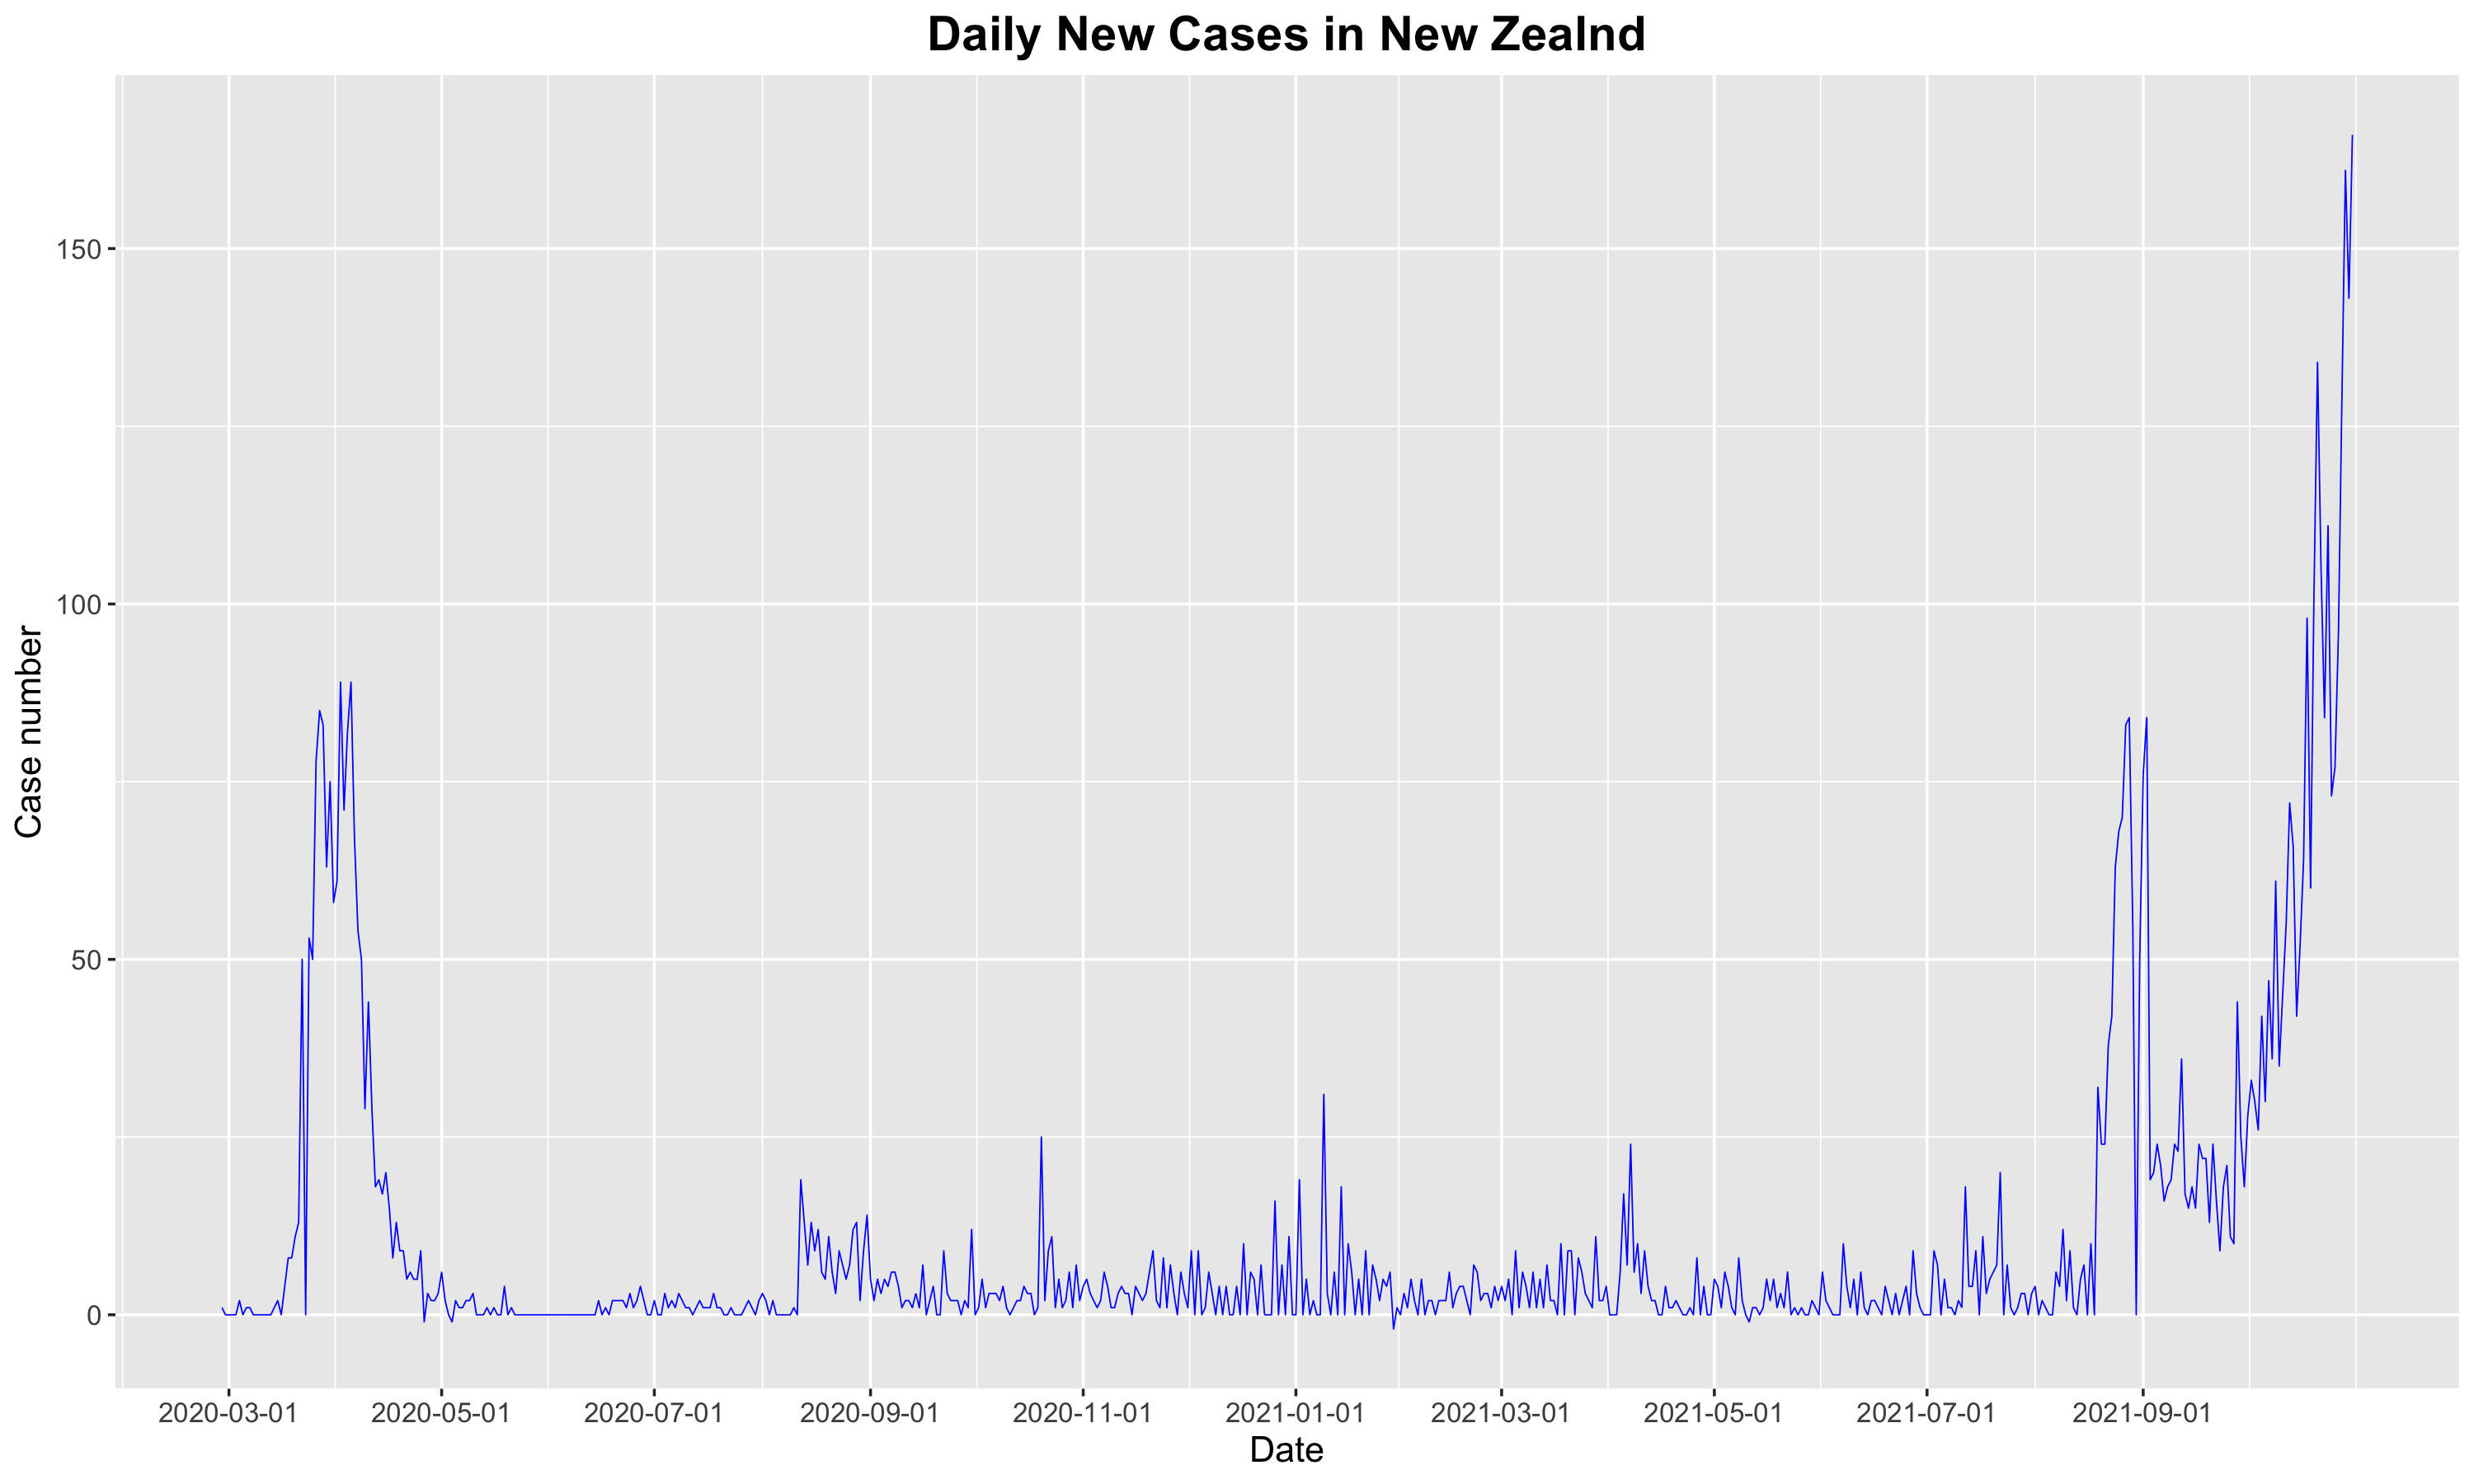

In [40]:
# select the New_Cases in final_long data set by filter its Type column
Case_plot <- final_long[grep(pattern="New_Cases",final_long$Type),] 
ggplot(data=Case_plot, aes(x=Period, y=Value))+
  geom_line(color = 'blue')+ # set line color to blue
  scale_x_date(breaks = datebreaks) + # format x dates
  labs(title = "Daily New Cases in New Zealnd")+ # set label title
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  xlab("Date") + # set x axis title
  ylab("Case number") + # set y axis title
  theme(axis.text.x = element_text(size=20), # set x axis size
        axis.text.y = element_text(size=20),#set y axis size
        axis.title.x = element_text(size = 26),#set x axis title size
        axis.title.y = element_text(size = 26))#set y axis title size

In [41]:
datebreaks <- seq(as.Date("2018-01-01"), as.Date("2021-10-30"), by = "4 month") # set the time period to 4 months

# Rent Graph

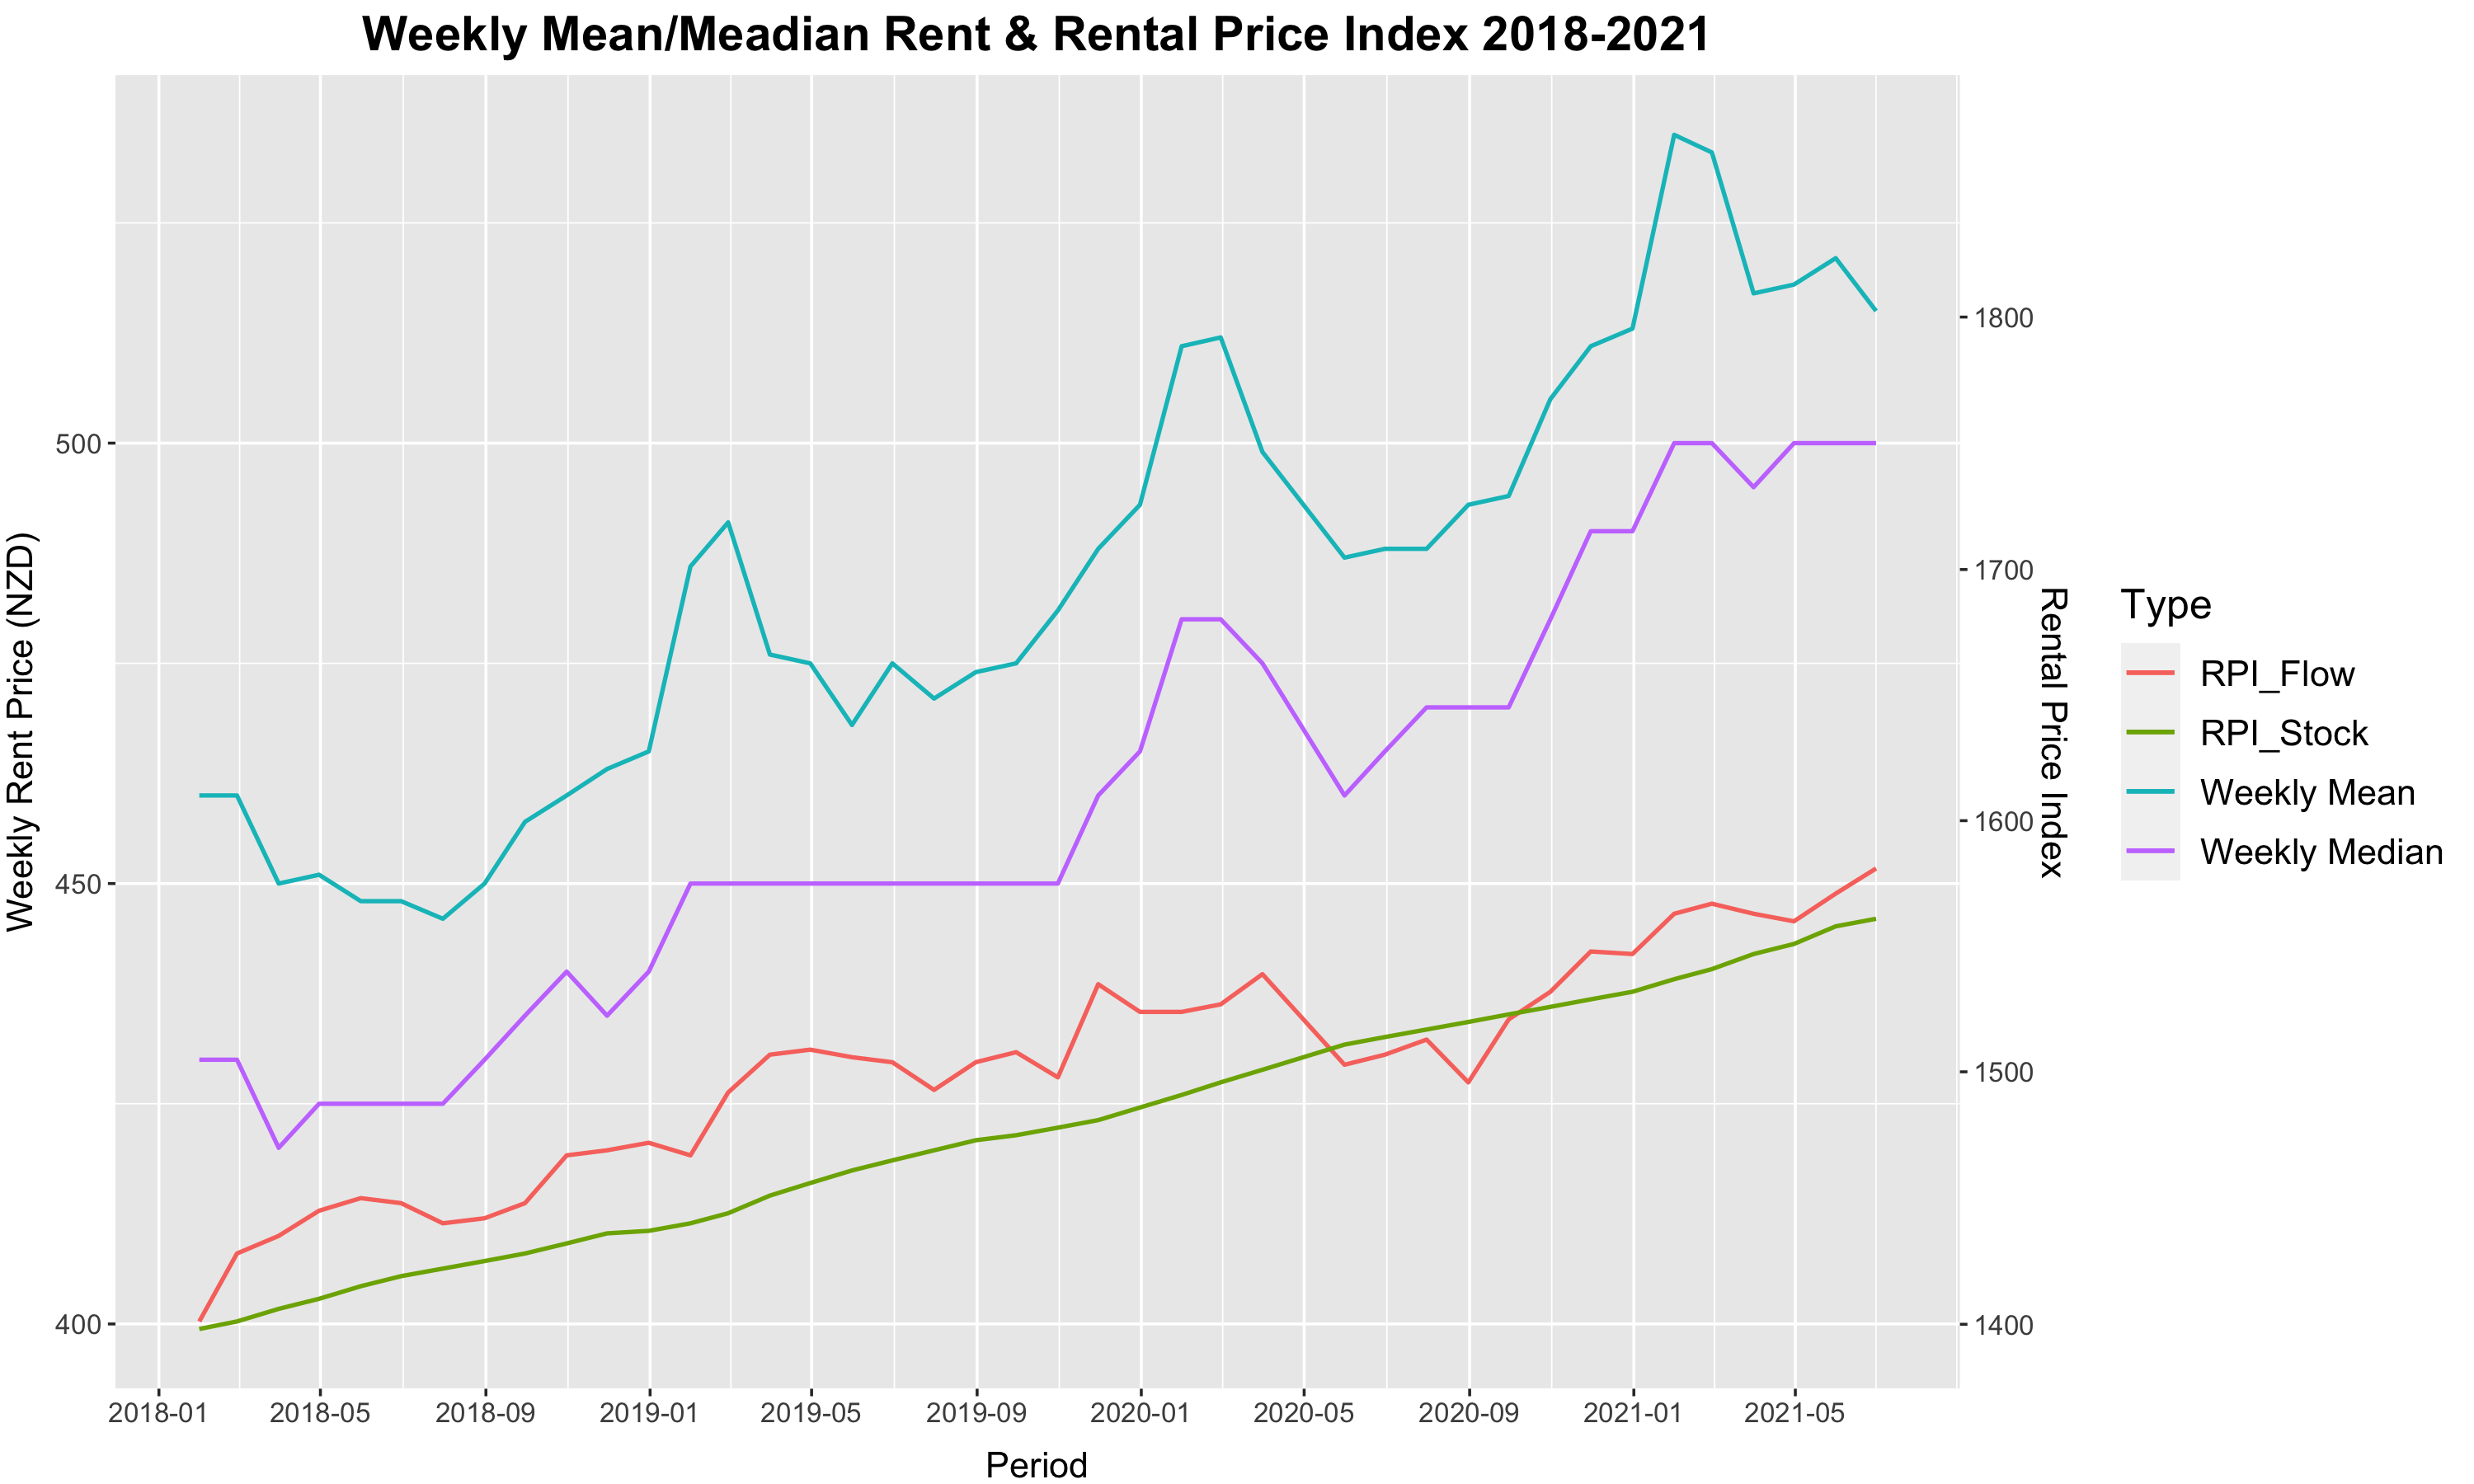

In [42]:
final_Monthly <- final_Monthly %>% na.omit() # removes any rows from the dataframe with NA values
#Draw a line chart, which contains Weekly Mean, Weekly Median, RPI_Flow and RPI_Stock
ggplot(data=final_Monthly, aes(x=Period))+
  #draw a line of Weekly Mean and set size to 1.5
  geom_line(size=1.5,linetype=1,aes(y=Weekly_Mean_Rent_Price, color="Weekly Mean"))+
  #draw a line of Weekly Median and set size to 1.5
  geom_line(size=1.5,linetype=1,aes(y=Weekly_Median_Rent_Price, color = "Weekly Median"))+
  #draw a line of RPI_Flow and set size to 1.5, set right y value
  geom_line(size=1.5,linetype=1,aes(y = RPI_Flow/3.5, color = "RPI_Flow"))+
  #draw a line of RPI_Stock and set size to 1.5, set right y value
  geom_line(size=1.5,linetype=1,aes(y = RPI_Stock/3.5, color = "RPI_Stock"))+
  # format the x axis period to year-month
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) + 
  #set right side y label to 3.5 times of the left y value, but the unit is different
  scale_y_continuous(sec.axis = sec_axis(~.*3.5, name = "Rental Price Index"))+
  #set graph title
  labs(title = "Weekly Mean/Meadian Rent & Rental Price Index 2018-2021")+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  #set bottom x lable
  xlab("Period") +
  #set right side y label
  ylab("Weekly Rent Price (NZD)") +
  labs(color = "Type")+ # set legend title
  theme(axis.text.x = element_text(size=20), # change axis x and y format
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26,vjust=-1), # set x axis title font size and position
        axis.title.y = element_text(size = 26,vjust=2,angle=90), # set y axis title font size and position
        legend.title = element_text(size=30), # set legend title font size
        legend.text = element_text(size=26), # set legend text font size
        legend.key.size = unit(3, "lines")) # set legend size

# NZAC Graph

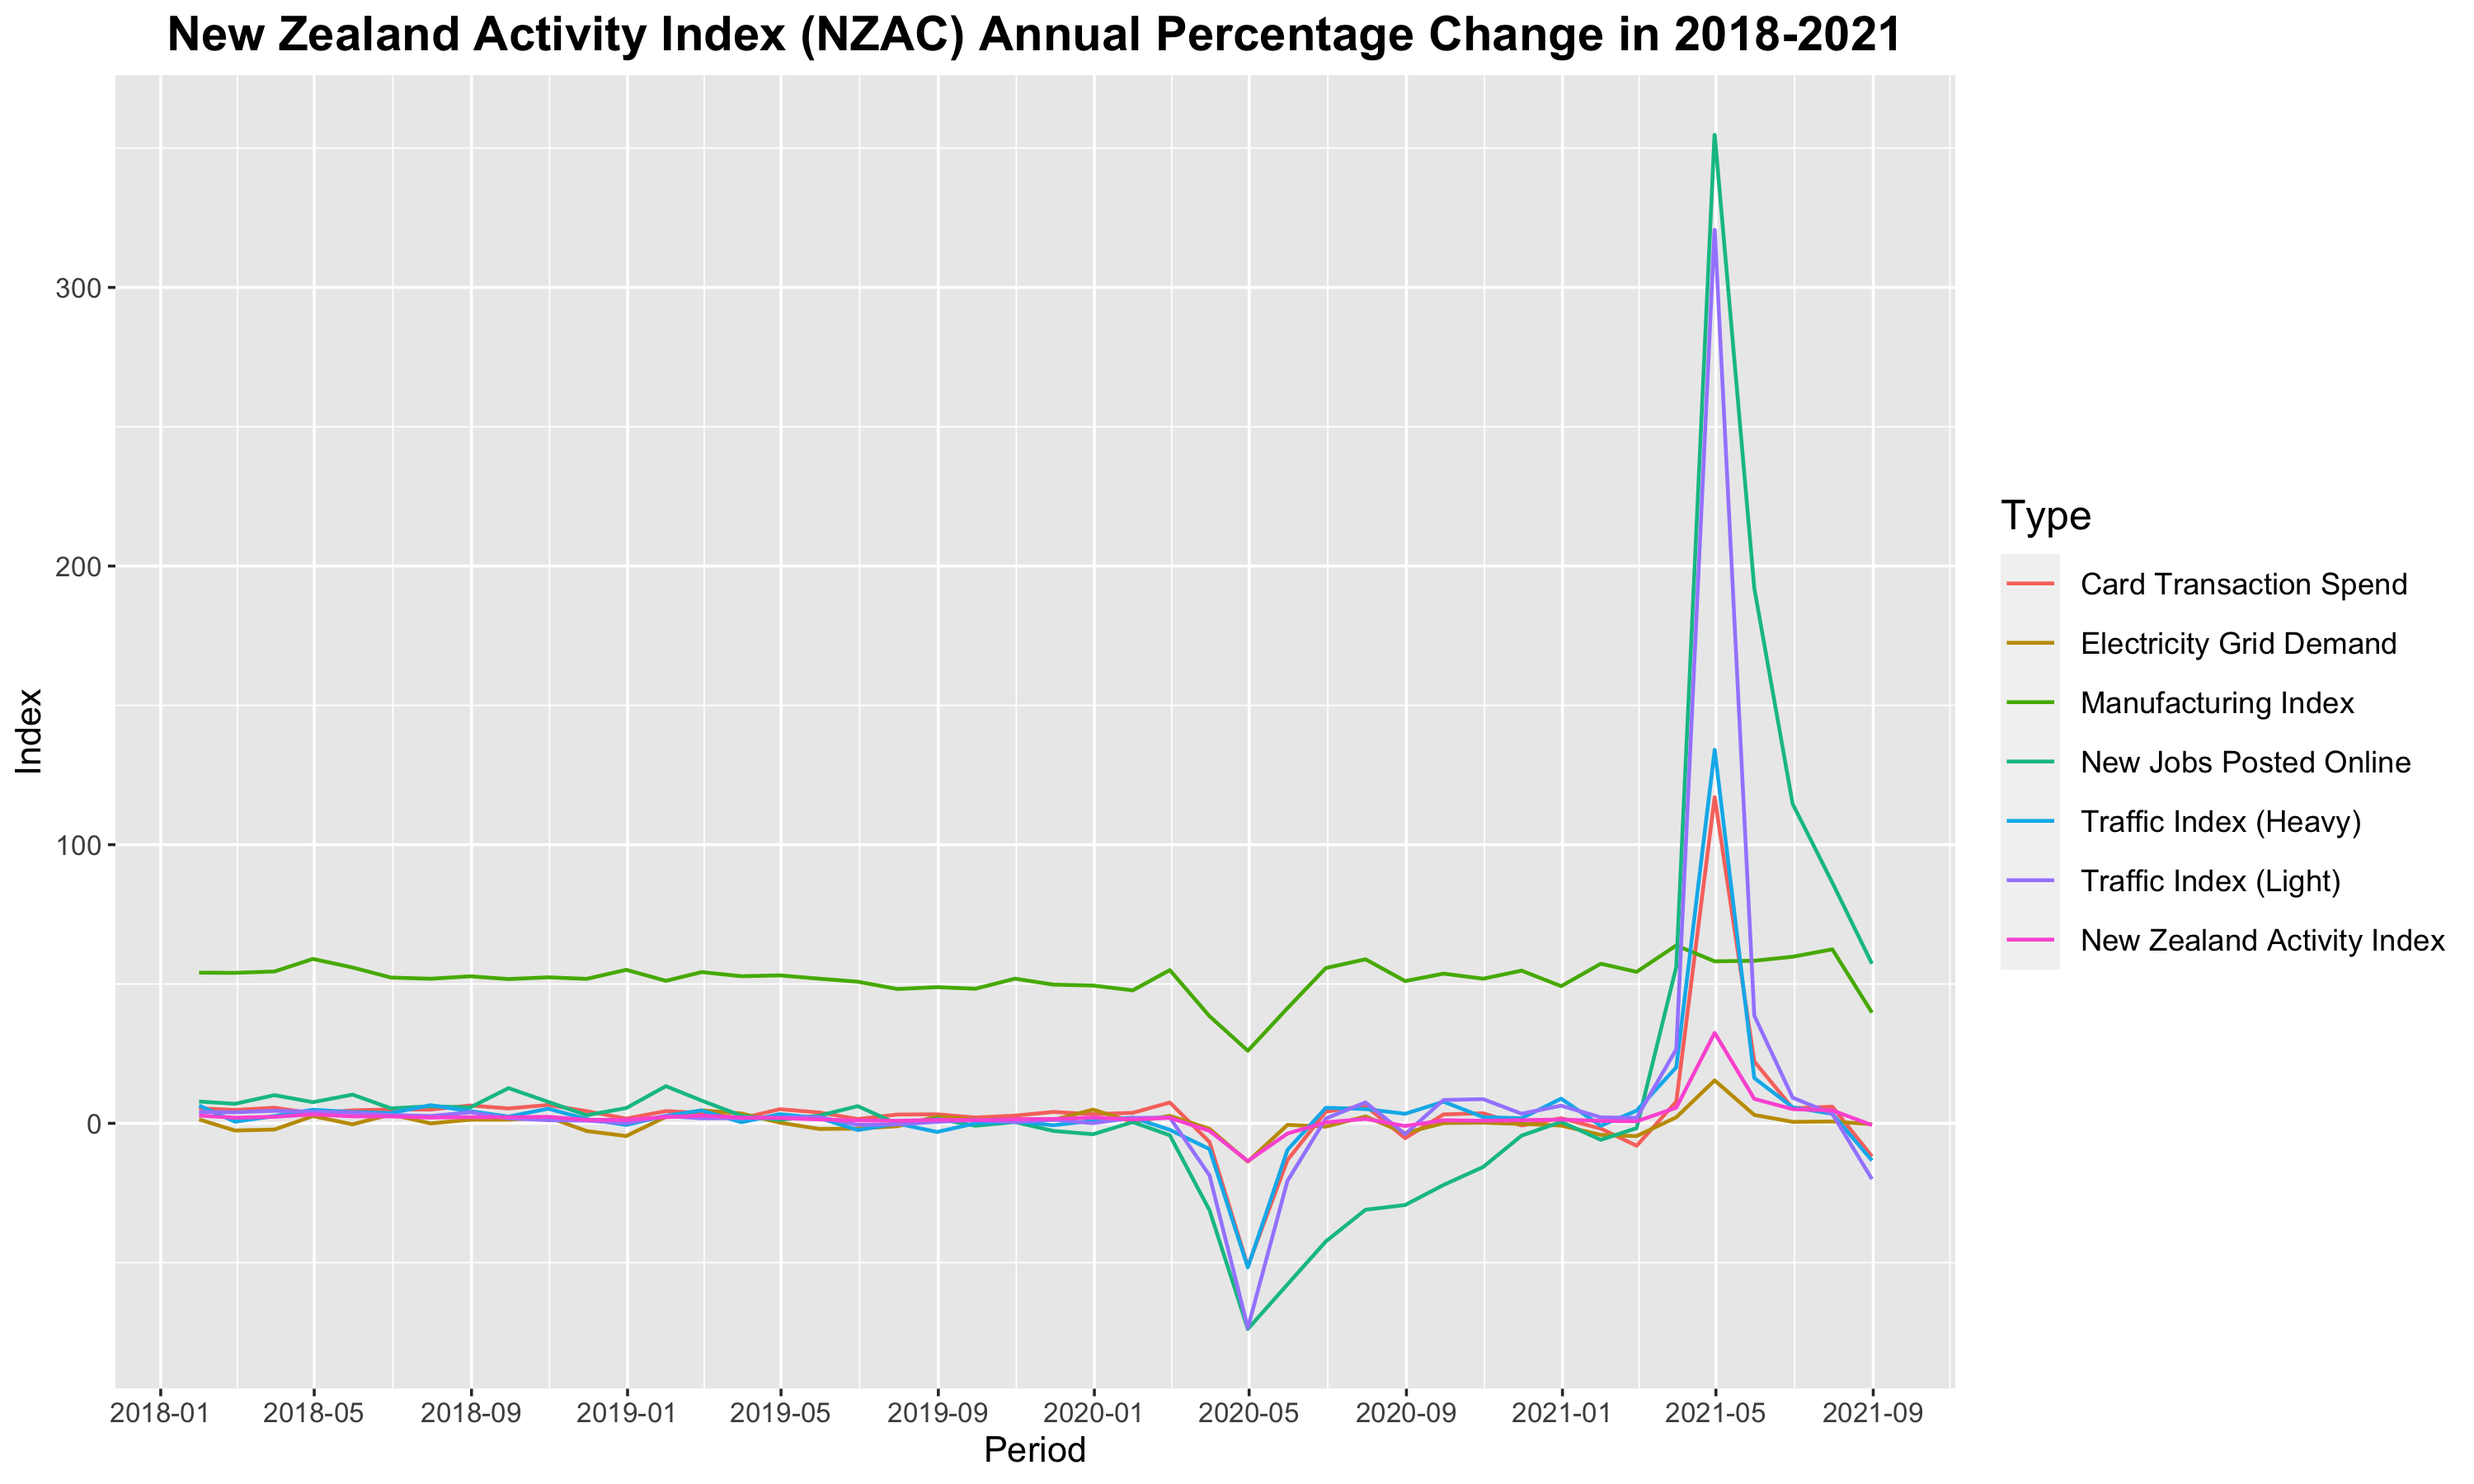

In [43]:
# select the NZAC related data in final_long data set by filter its Type column
NZAC_plot <- final_long[grep(pattern="^NZAC",final_long$Type),] 
# Plot the New Zealand Activity Index (NZAC) Annual Percentage Change in 2018-2021
ggplot(data=NZAC_plot, aes(x=Period, y=Value, group=Type, color=Type))+ # choose data from NZAC and group it by Type
  geom_line(size = 1.3)+ # Set the line size 
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) + # Set the date break
  labs(title = "New Zealand Activity Index (NZAC) Annual Percentage Change in 2018-2021")+ # Set the graph title
  xlab("Period") + # Set x axis label title
  ylab("Index") + # Set y axis label title
  labs(color = "Type")+ # Set legend title             # Rename the legends
  scale_color_discrete(labels = c("Card Transaction Spend","Electricity Grid Demand","Manufacturing Index","New Jobs Posted Online","Traffic Index (Heavy)","Traffic Index (Light)","New Zealand Activity Index"))+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold"), # Set title format
        axis.text.x = element_text(size=20), # Set axis x text format
        axis.text.y = element_text(size=20), # Set axis y text format
        axis.title.x = element_text(size = 26), # Set axis x title format
        axis.title.y = element_text(size = 26), # Set axis y title format
        legend.title = element_text(size=30), # Set legend title format
        legend.text = element_text(size=22), # Set legend text format
        legend.key.size = unit(3, "lines")) # Set legend size

# HPI Graph

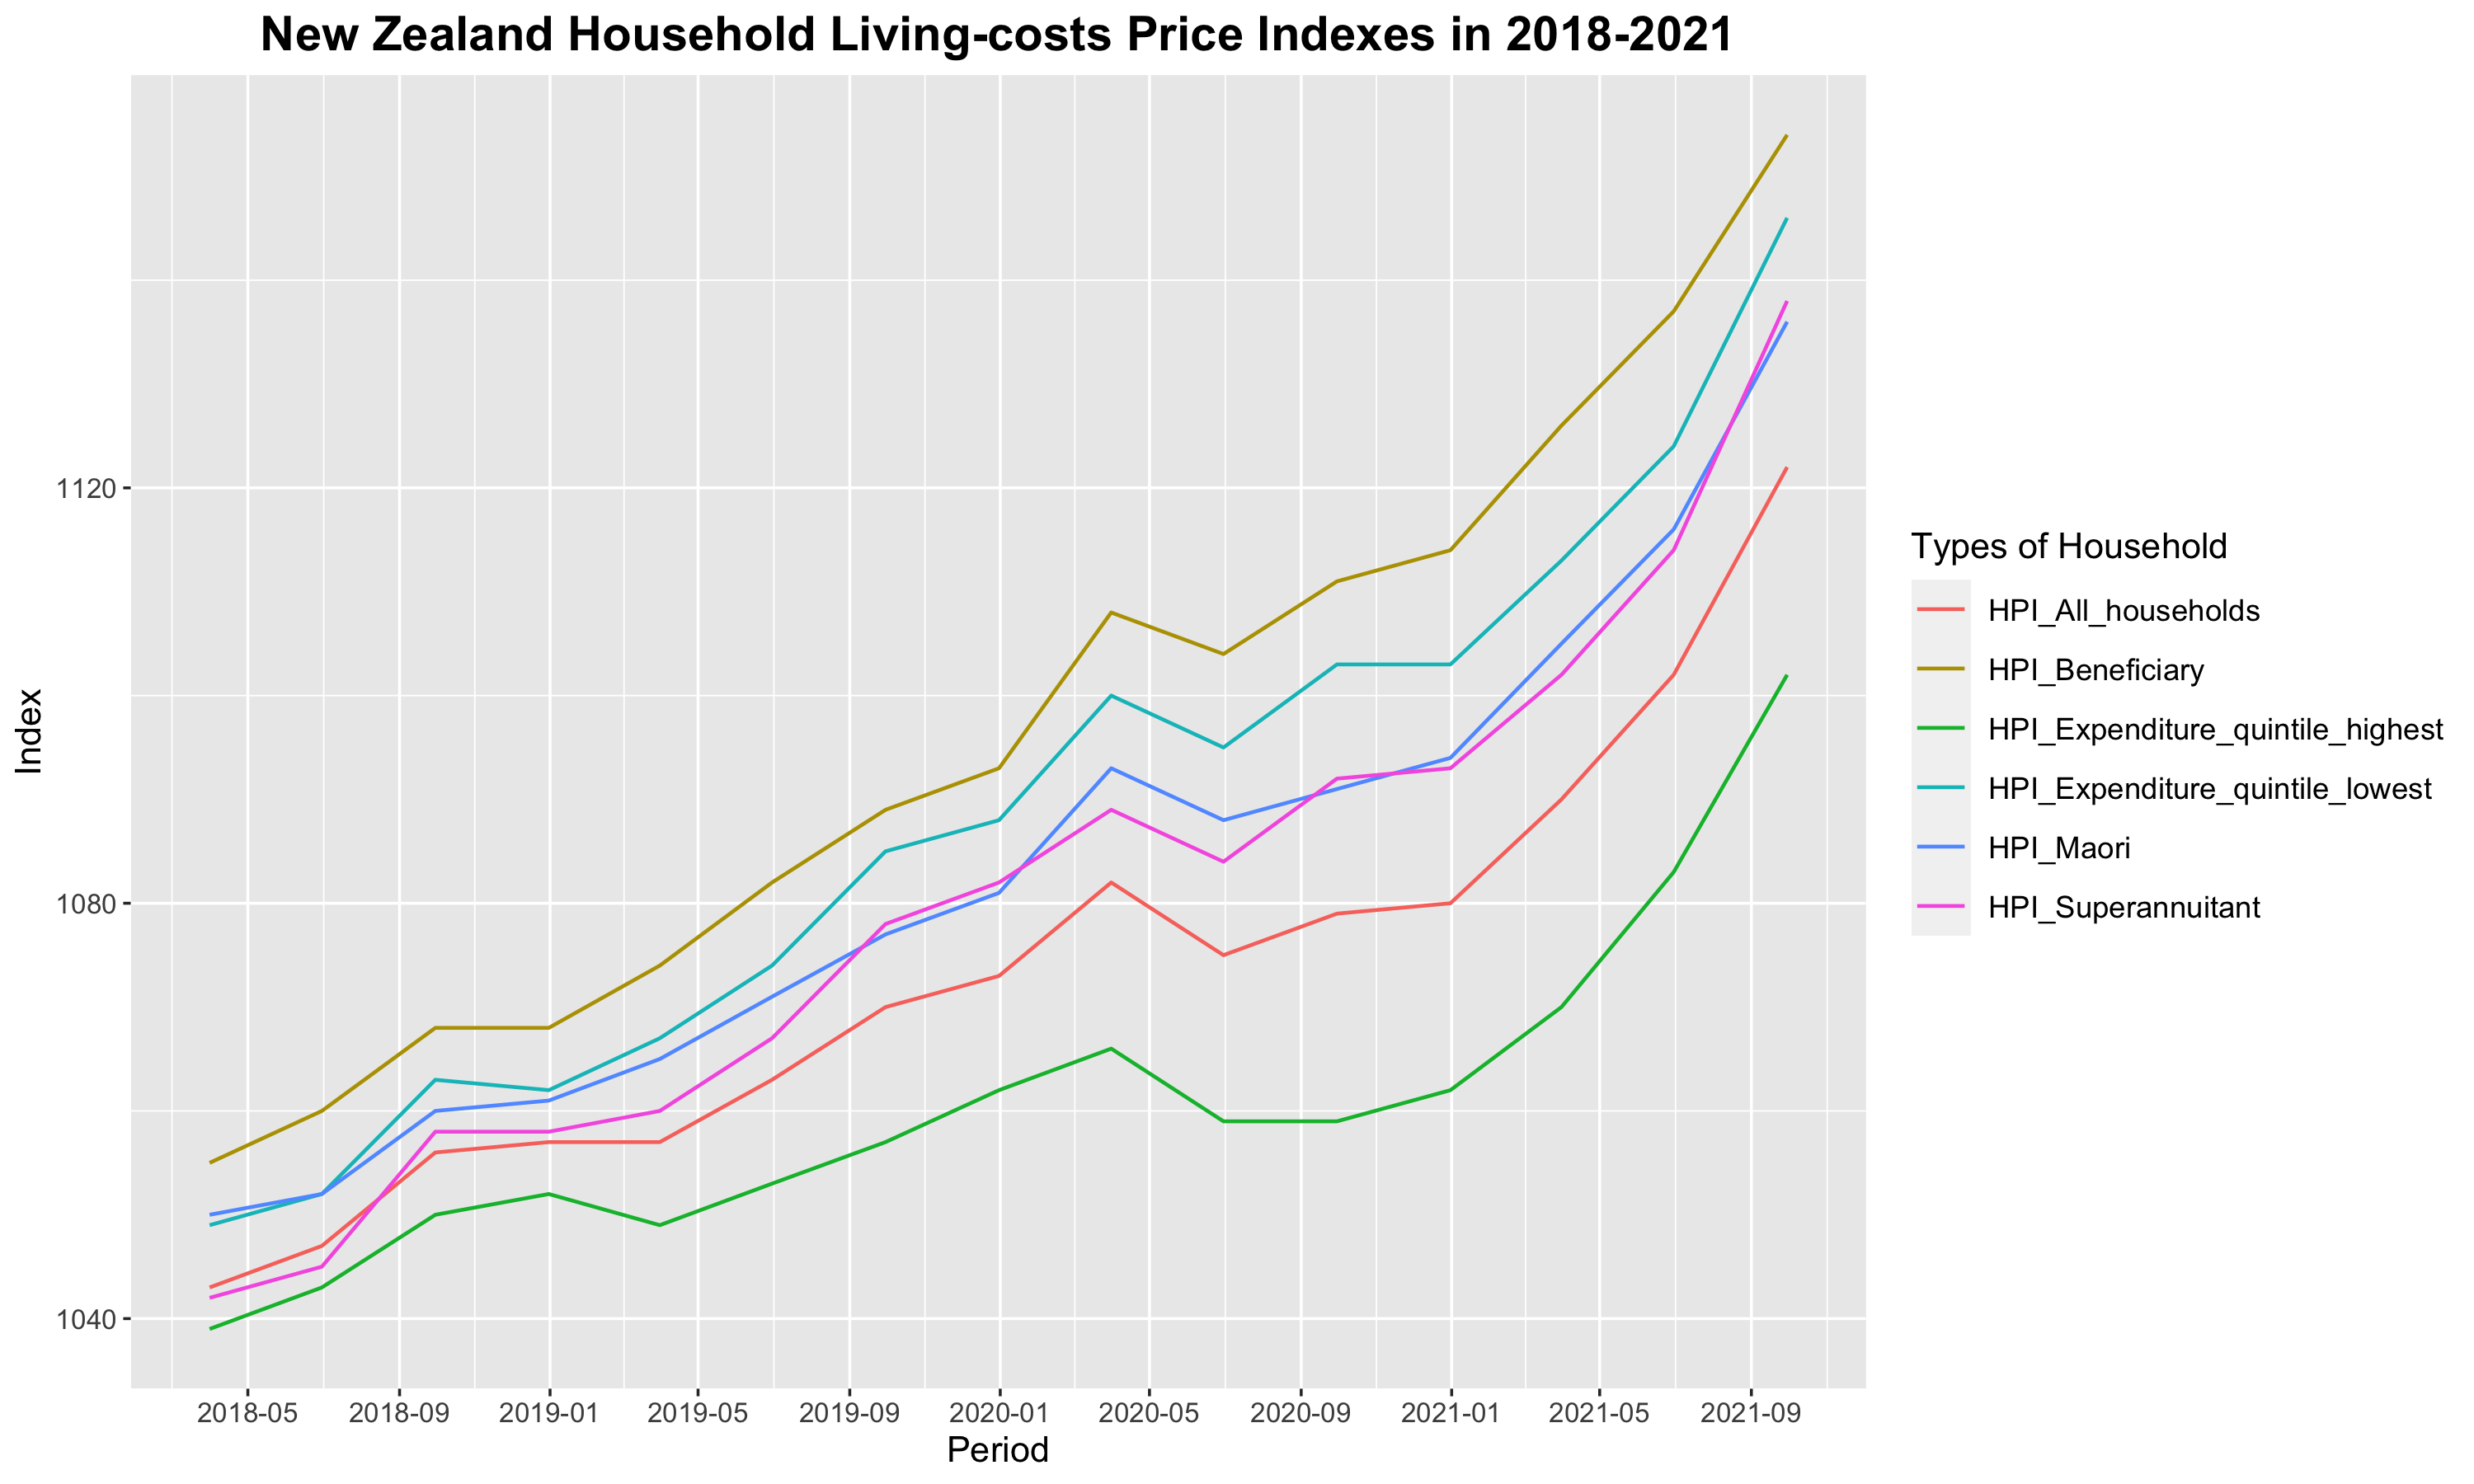

In [44]:
# select the HPI related data in final_long data set by filter its Type column
HPI_plot <- final_long[grep(pattern="^HPI",final_long$"Type"),]
#plot line chart of Household Living-costs Price Indexes,which cantans six different types of index
ggplot(data=HPI_plot, aes(x=Period, y=Value, group=Type, color=Type))+ 
  geom_line(size = 1.3)+
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) + # set x period date format
  #set chart title content
  labs(title = "New Zealand Household Living-costs Price Indexes in 2018-2021")+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  xlab("Period") +#set x axis lable 
  ylab("Index") +#set y axis lable
  labs(color = "Types of Household")+#set right side lable intro
  theme(axis.text.x = element_text(size=20), # change two axis text font size
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set x axis title font size
        axis.title.y = element_text(size = 26),#set y axis title font size
        legend.title = element_text(size=26),#set legend title font size
        legend.text = element_text(size=22),#set legend text font size
        legend.key.size = unit(3, "lines")) # set legend size

# CPI Graph

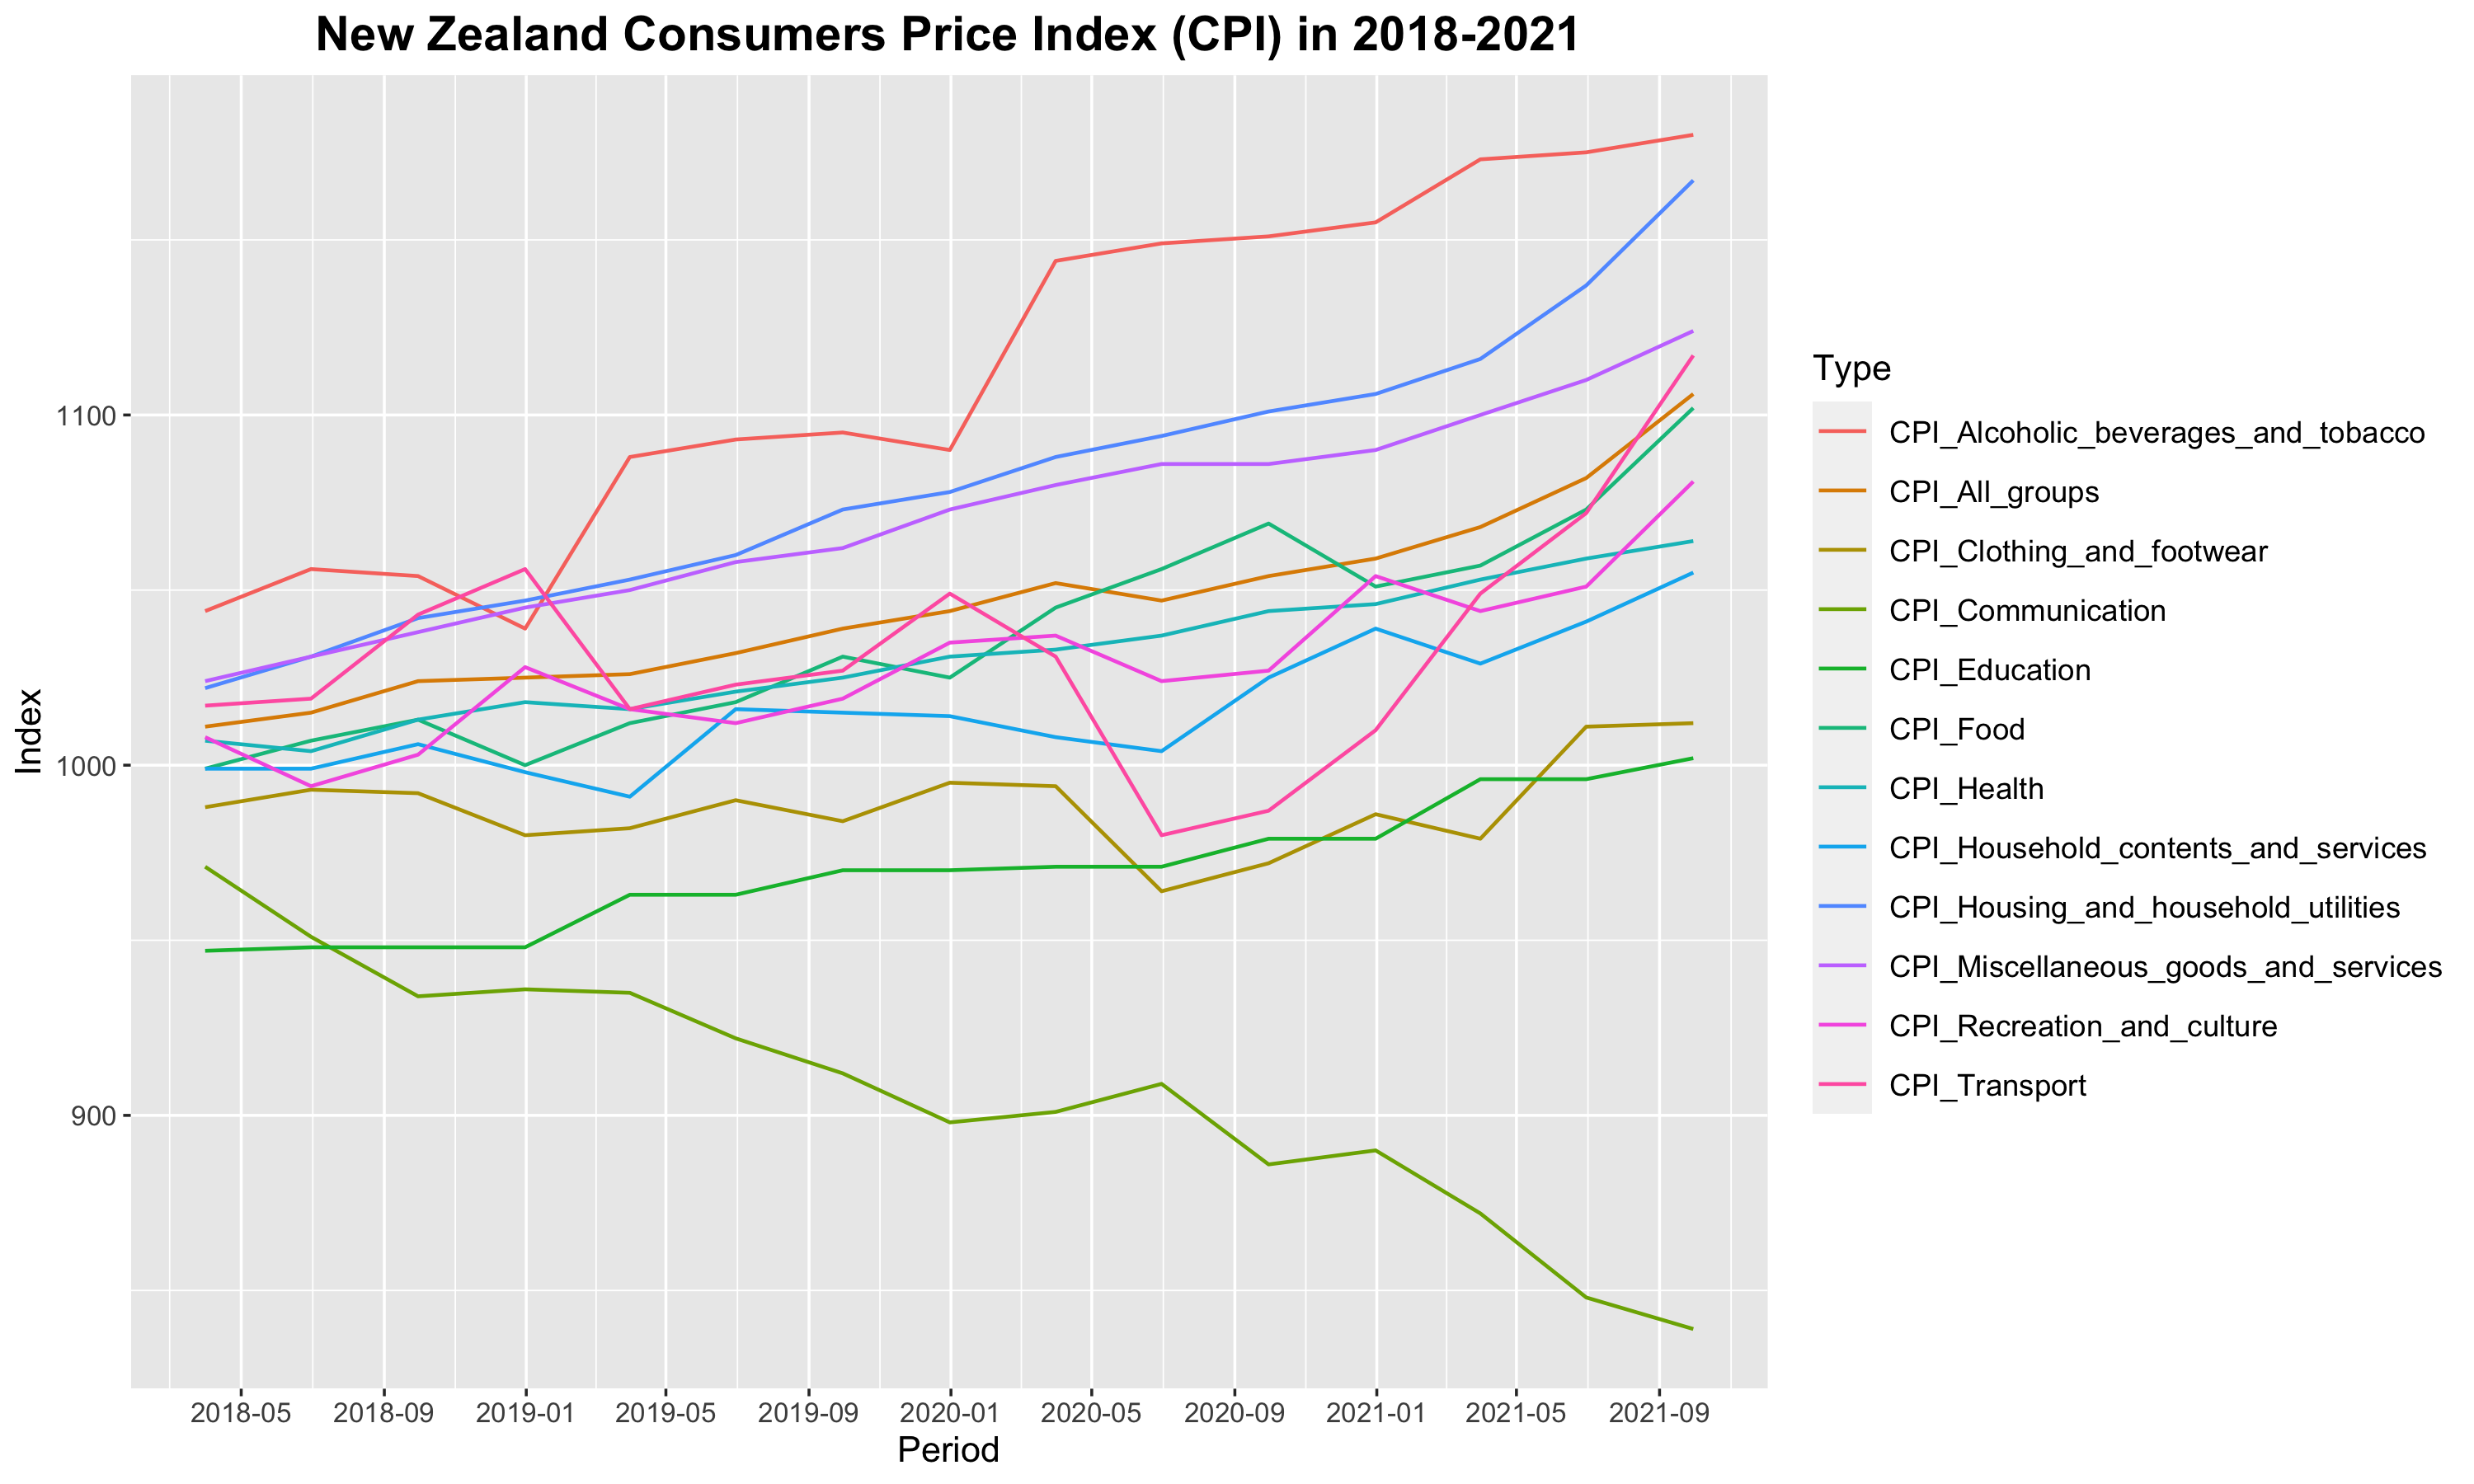

In [45]:
# select the CPI related data in final_long data set by filter its Type column
CPI_plot <- final_long[grep(pattern="^CPI",final_long$"Type"),]
#plot 12 differents CPI in one chart
ggplot(data=CPI_plot, aes(x=Period, y=Value, group=Type, color=Type))+ 
  geom_line(size = 1.3)+
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) +
  labs(title = "New Zealand Consumers Price Index (CPI) in 2018-2021")+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  xlab("Period") +
  ylab("Index") +
  labs(color = "Type")+
  theme(axis.text.x = element_text(size=20), # change two axis text font size
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set x axis title font size
        axis.title.y = element_text(size = 26),#set y axis title font size
        legend.title = element_text(size=26),#set legend title font size
        legend.text = element_text(size=22),#set legend text font size
        legend.key.size = unit(3, "lines"))
 
p <- ggplot(data = CPI_plot,
  mapping = aes(# mapping value into graph
    x = Period, 
    y = Value,
    fill = Type)) 


# FPI Graph

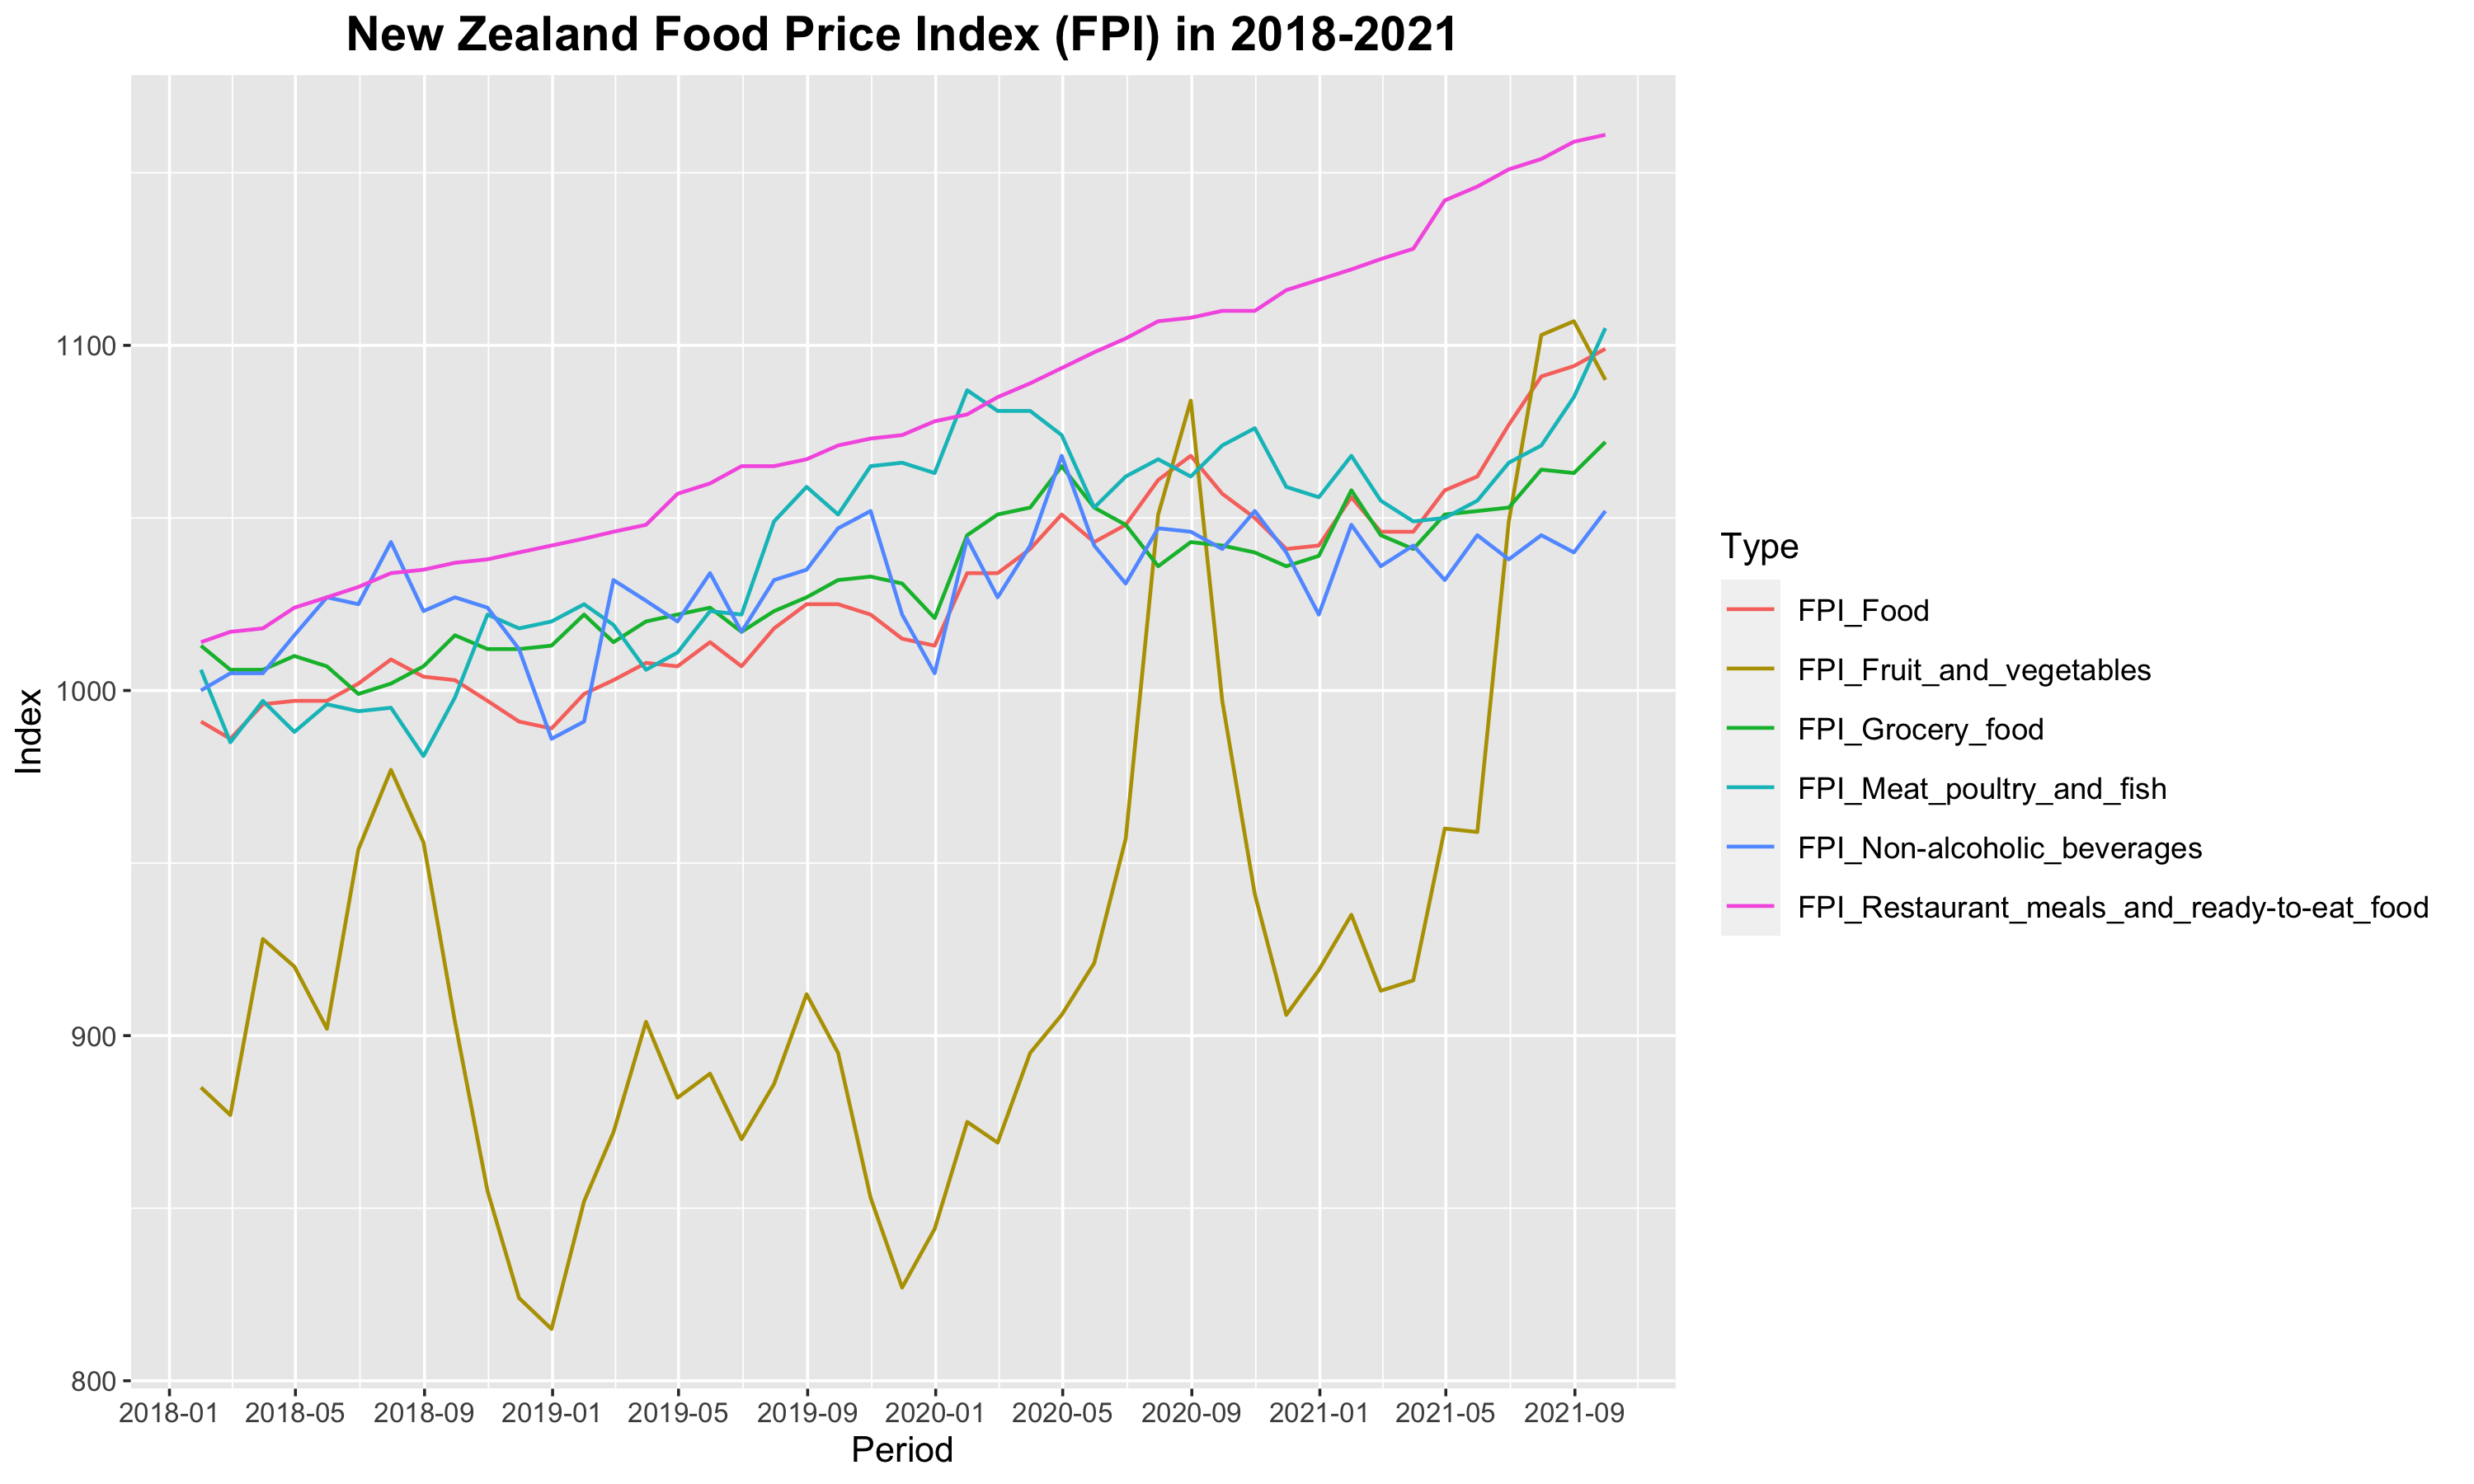

In [46]:
# select the FPI related data in final_long data set by filter its Type column
FPI_plot <- final_long[grep(pattern="^FPI",final_long$"Type"),]
#plot 12 differents FPI in one chart
ggplot(data=FPI_plot, aes(x=Period, y=Value, group=Type, color=Type))+ 
  geom_line(size = 1.3)+
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) +
  labs(title = "New Zealand Food Price Index (FPI) in 2018-2021")+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  xlab("Period") +
  ylab("Index") +
  labs(color = "Type")+
  theme(axis.text.x = element_text(size=20), # change two axis text font size
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set x axis title font size
        axis.title.y = element_text(size = 26),#set y axis title font size
        legend.title = element_text(size=26),#set legend title font size
        legend.text = element_text(size=22),#set legend text font size
        legend.key.size = unit(3, "lines"))
 
p <- ggplot(data = CPI_plot,
  mapping = aes(#mapping value into graph
    x = Period, 
    y = Value,
    fill = Type)) 

# Unemployment Rate & Weekly Earnings Graph

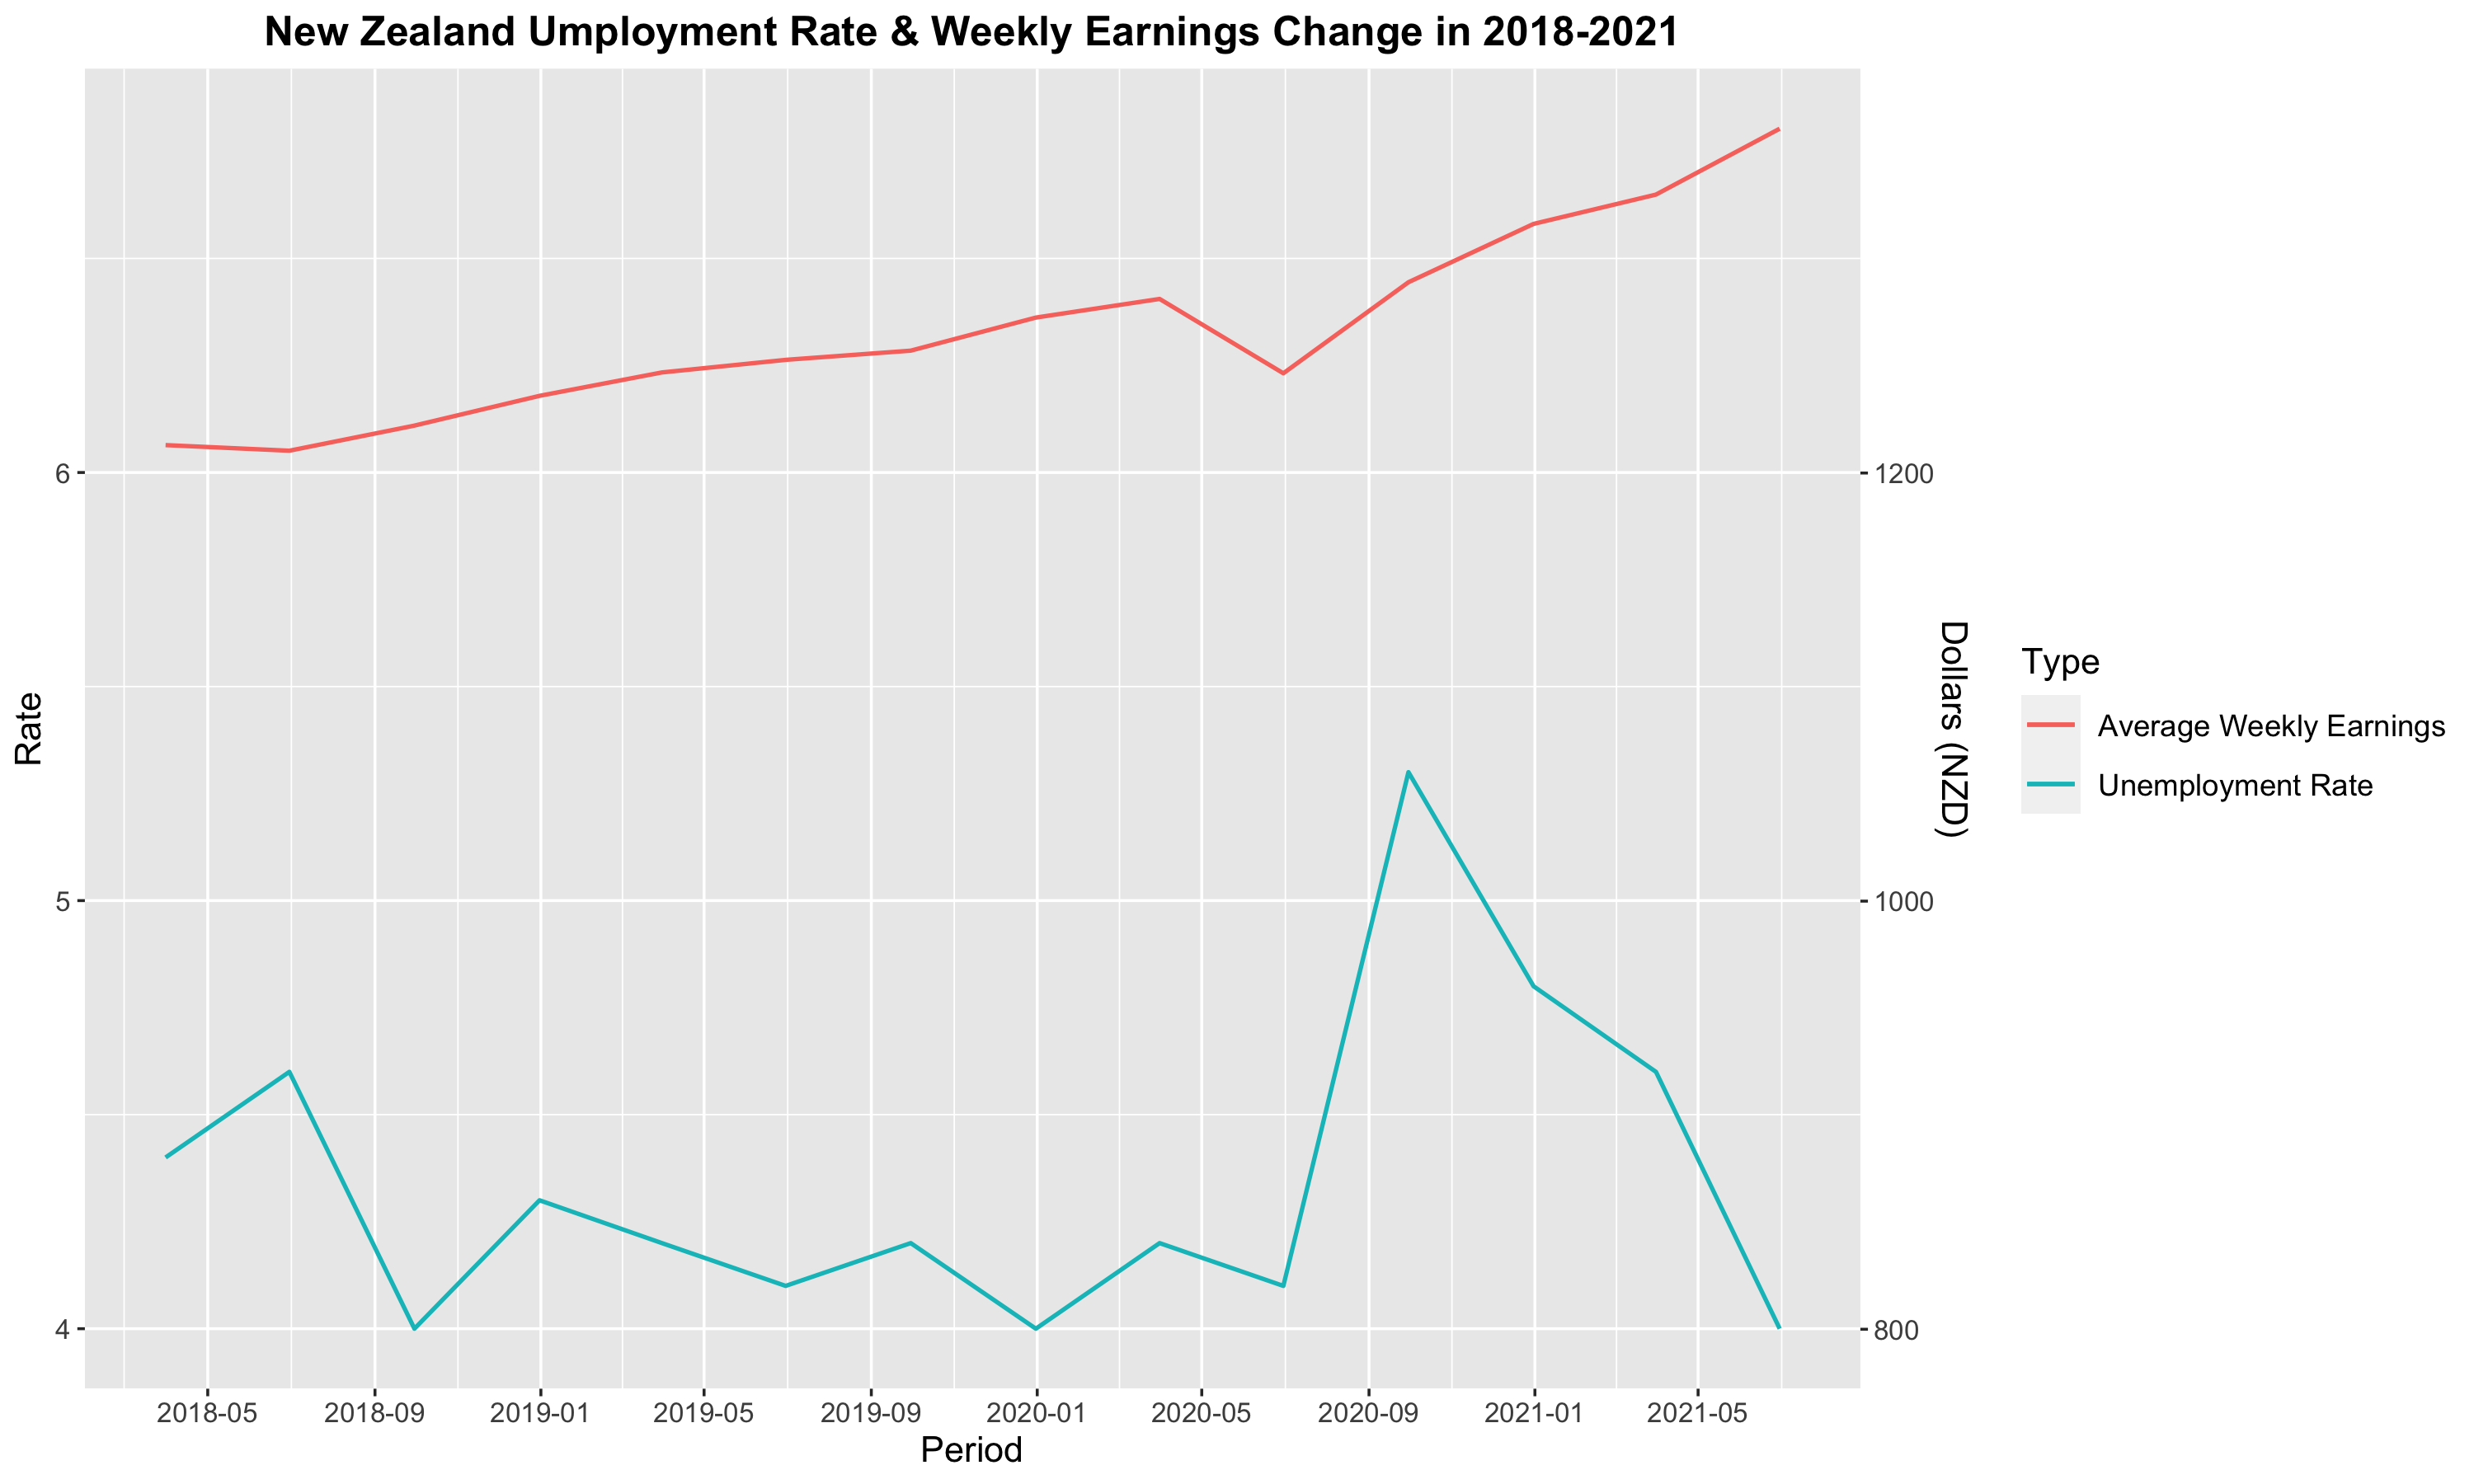

In [47]:
final_Quarterly <- final_Quarterly %>% na.omit() #removes any rows from the dataframe with NA values
ggplot(data=final_Quarterly, aes(x=Period))+ 
  #plot two different values in to one graph by Y axis
  geom_line(size=1.5,linetype=1,aes(y=Unemployment_Rate, color = "Unemployment Rate"))+
  geom_line(size=1.5,linetype=1,aes(y = Weekly_Earnings/200, color = "Average Weekly Earnings"))+
  scale_y_continuous(sec.axis = sec_axis(~.*200, name = "Dollars (NZD)"))+#set chart right side lable font size and content
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) +
  labs(title = "New Zealand Umployment Rate & Weekly Earnings Change in 2018-2021")+#set chart title content
  theme(plot.title = element_text(hjust=0.5,size = 30, face="bold")) + # change title format
  xlab("Period") +#set x axis lable
  ylab("Rate") +#set y axis lable
  labs(color = "Type")+#set graph right side intro 
  theme(axis.text.x = element_text(size=20), # change axis x and y format
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set x axis title font size
        axis.title.y = element_text(size = 26),#set y axis title font size
        legend.title = element_text(size=26),#set legend title font size
        legend.text = element_text(size=22),#set legend text font size
        legend.key.size = unit(3, "lines"))



# Price Indexes Graph

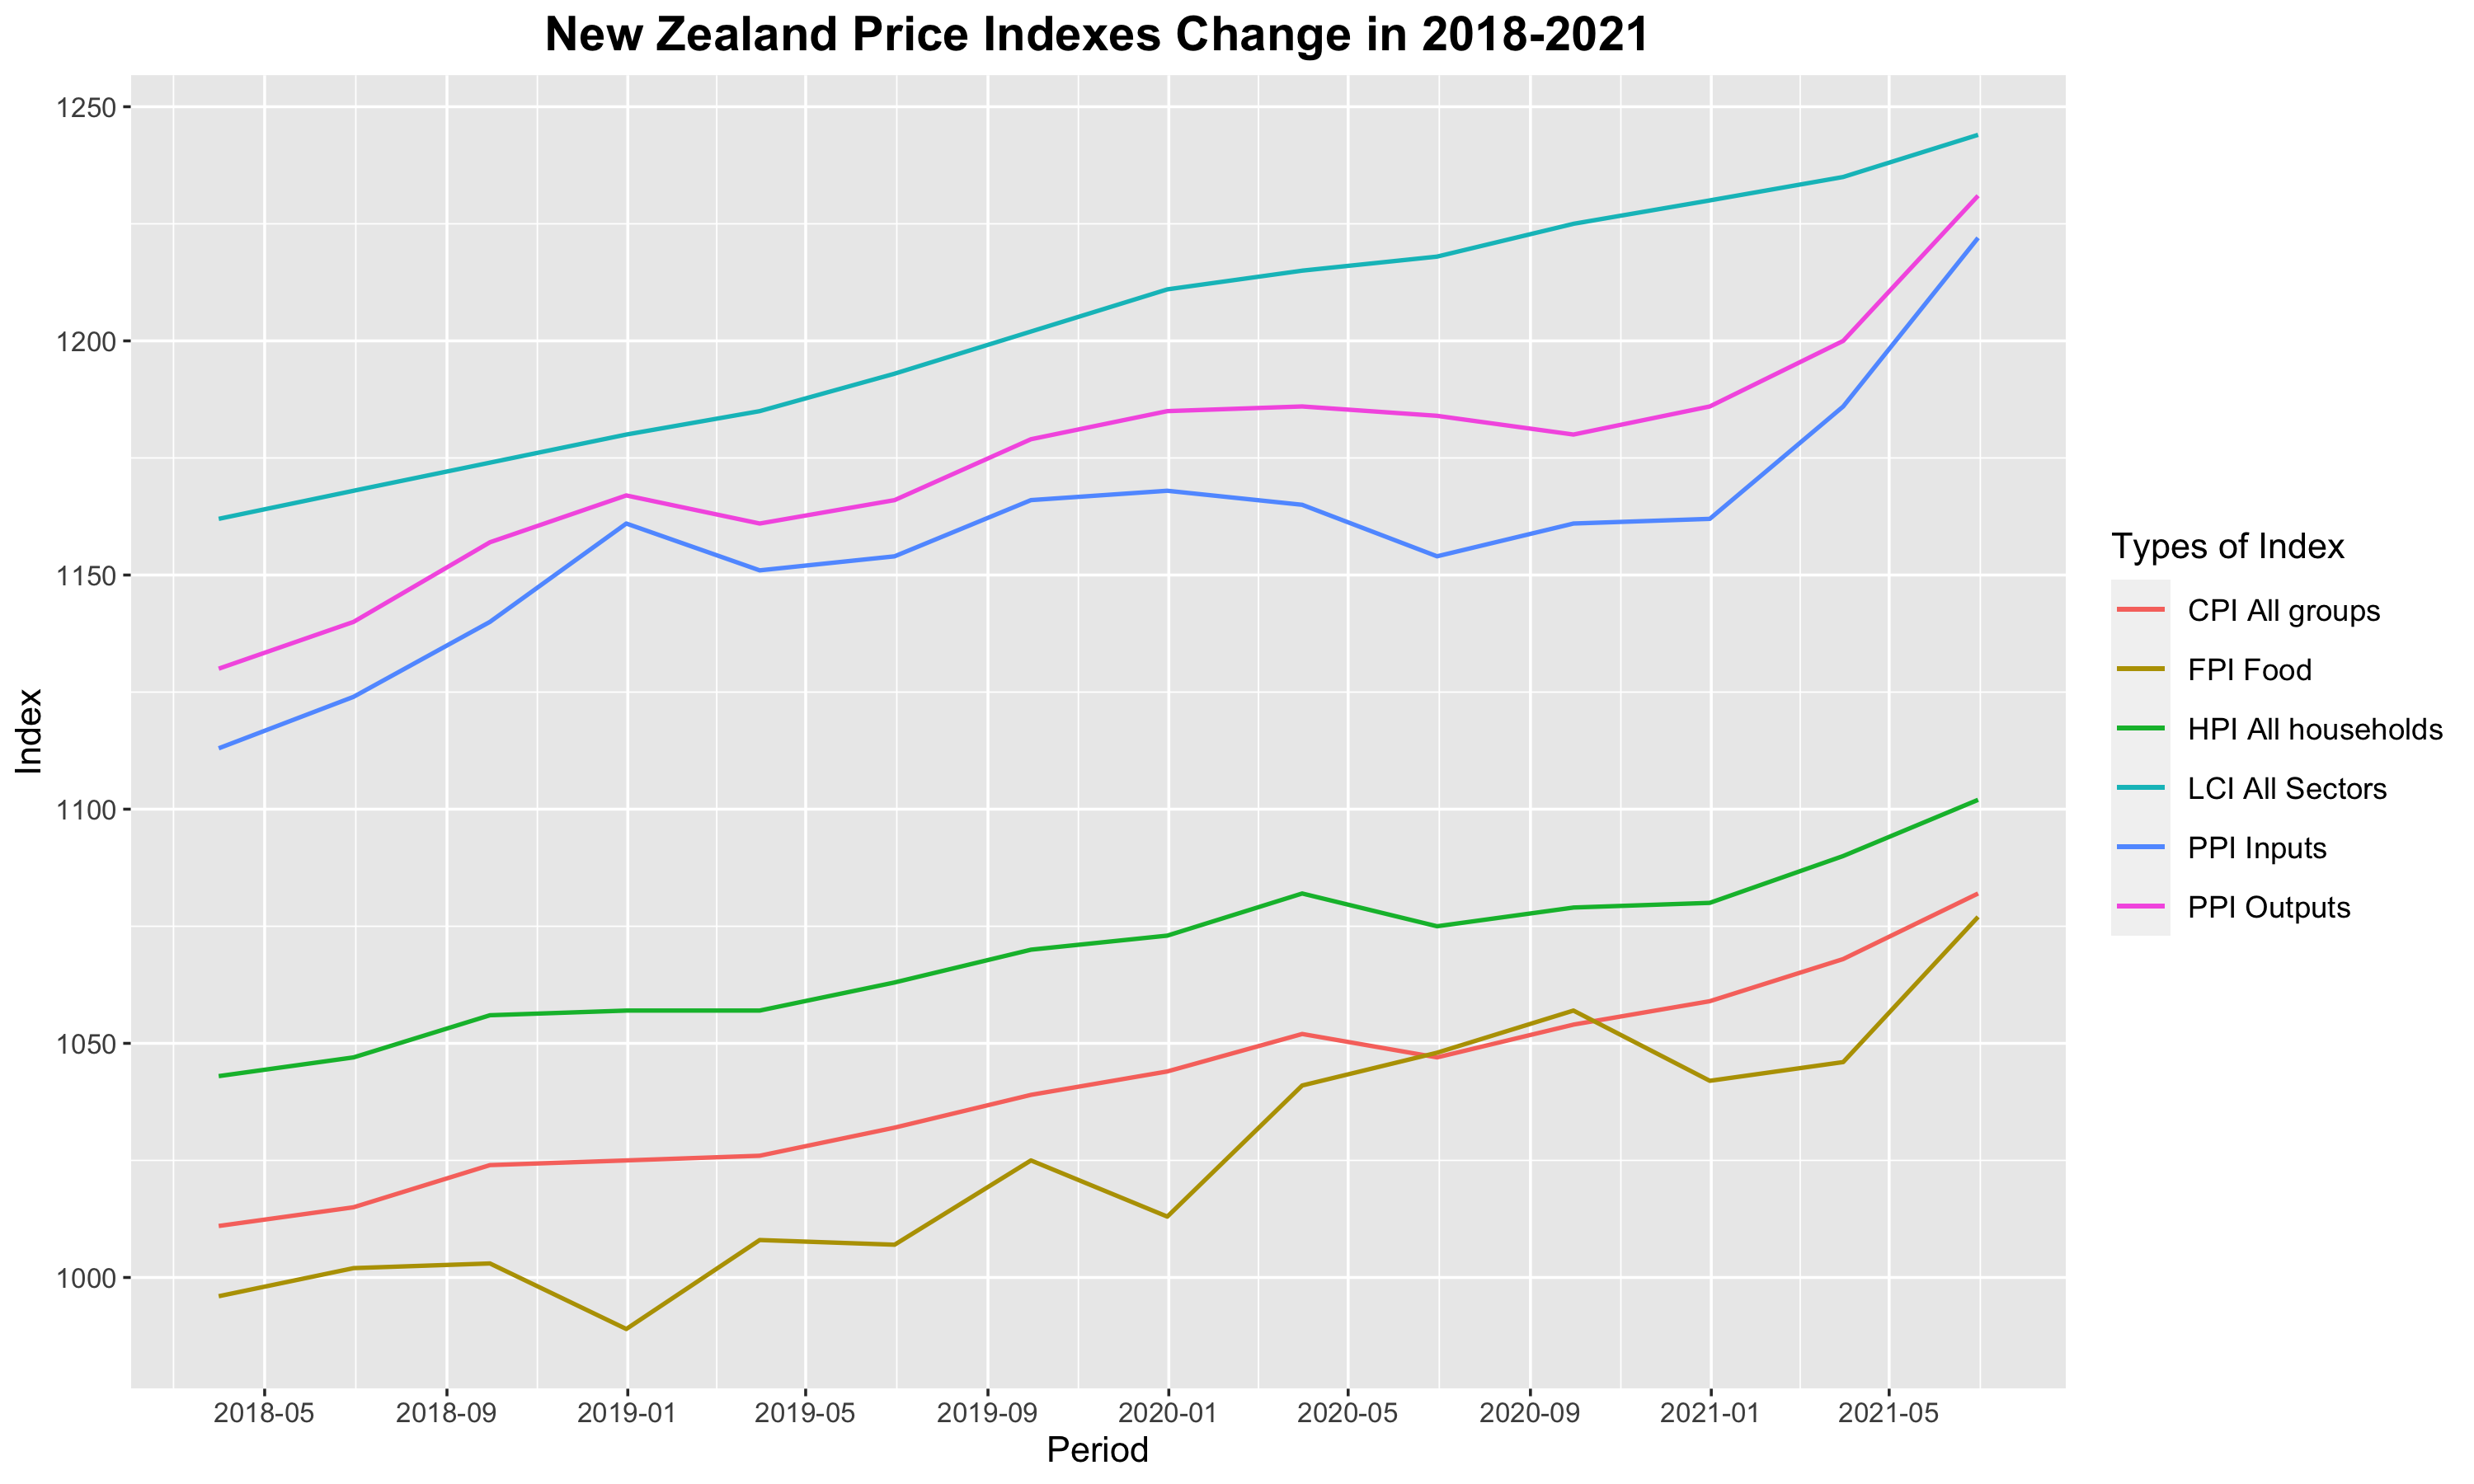

In [48]:
final_Quarterly <- final_Quarterly %>% na.omit() #removes any rows from the dataframe with NA values
#plot eight different types of price index into one chart
ggplot(NULL,aes(x=Period))+ 
  #draw 8 diferent types of index at chart by Y axis
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y=CPI_All_groups, color="CPI All groups"))+
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y=HPI_All_households, color = "HPI All households"))+
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y = PPI_Inputs, color = "PPI Inputs"))+
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y = PPI_Outputs, color = "PPI Outputs"))+
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y = LCI_All_Sectors, color = "LCI All Sectors"))+
  geom_line(data=final_Quarterly, size=1.5,linetype=1,aes(y = FPI_Food, color = "FPI Food"))+
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) +
  labs(title = "New Zealand Price Indexes Change in 2018-2021")+
  theme(plot.title = element_text(hjust=0.5,size = 35, face="bold")) + # change title format
  xlab("Period") +#set x axis lable
  ylab("Index") +#set y axis lable
  labs(color = "Types of Index")+
  theme(axis.text.x = element_text(size=20), # change axis x and y font size
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set x axis title font size
        axis.title.y = element_text(size = 26),#set y axis title font size
        legend.title = element_text(size=26),#set legend title font size
        legend.text = element_text(size=22),#set legend text font size
        legend.key.size = unit(3, "lines"))

# Trade Graph

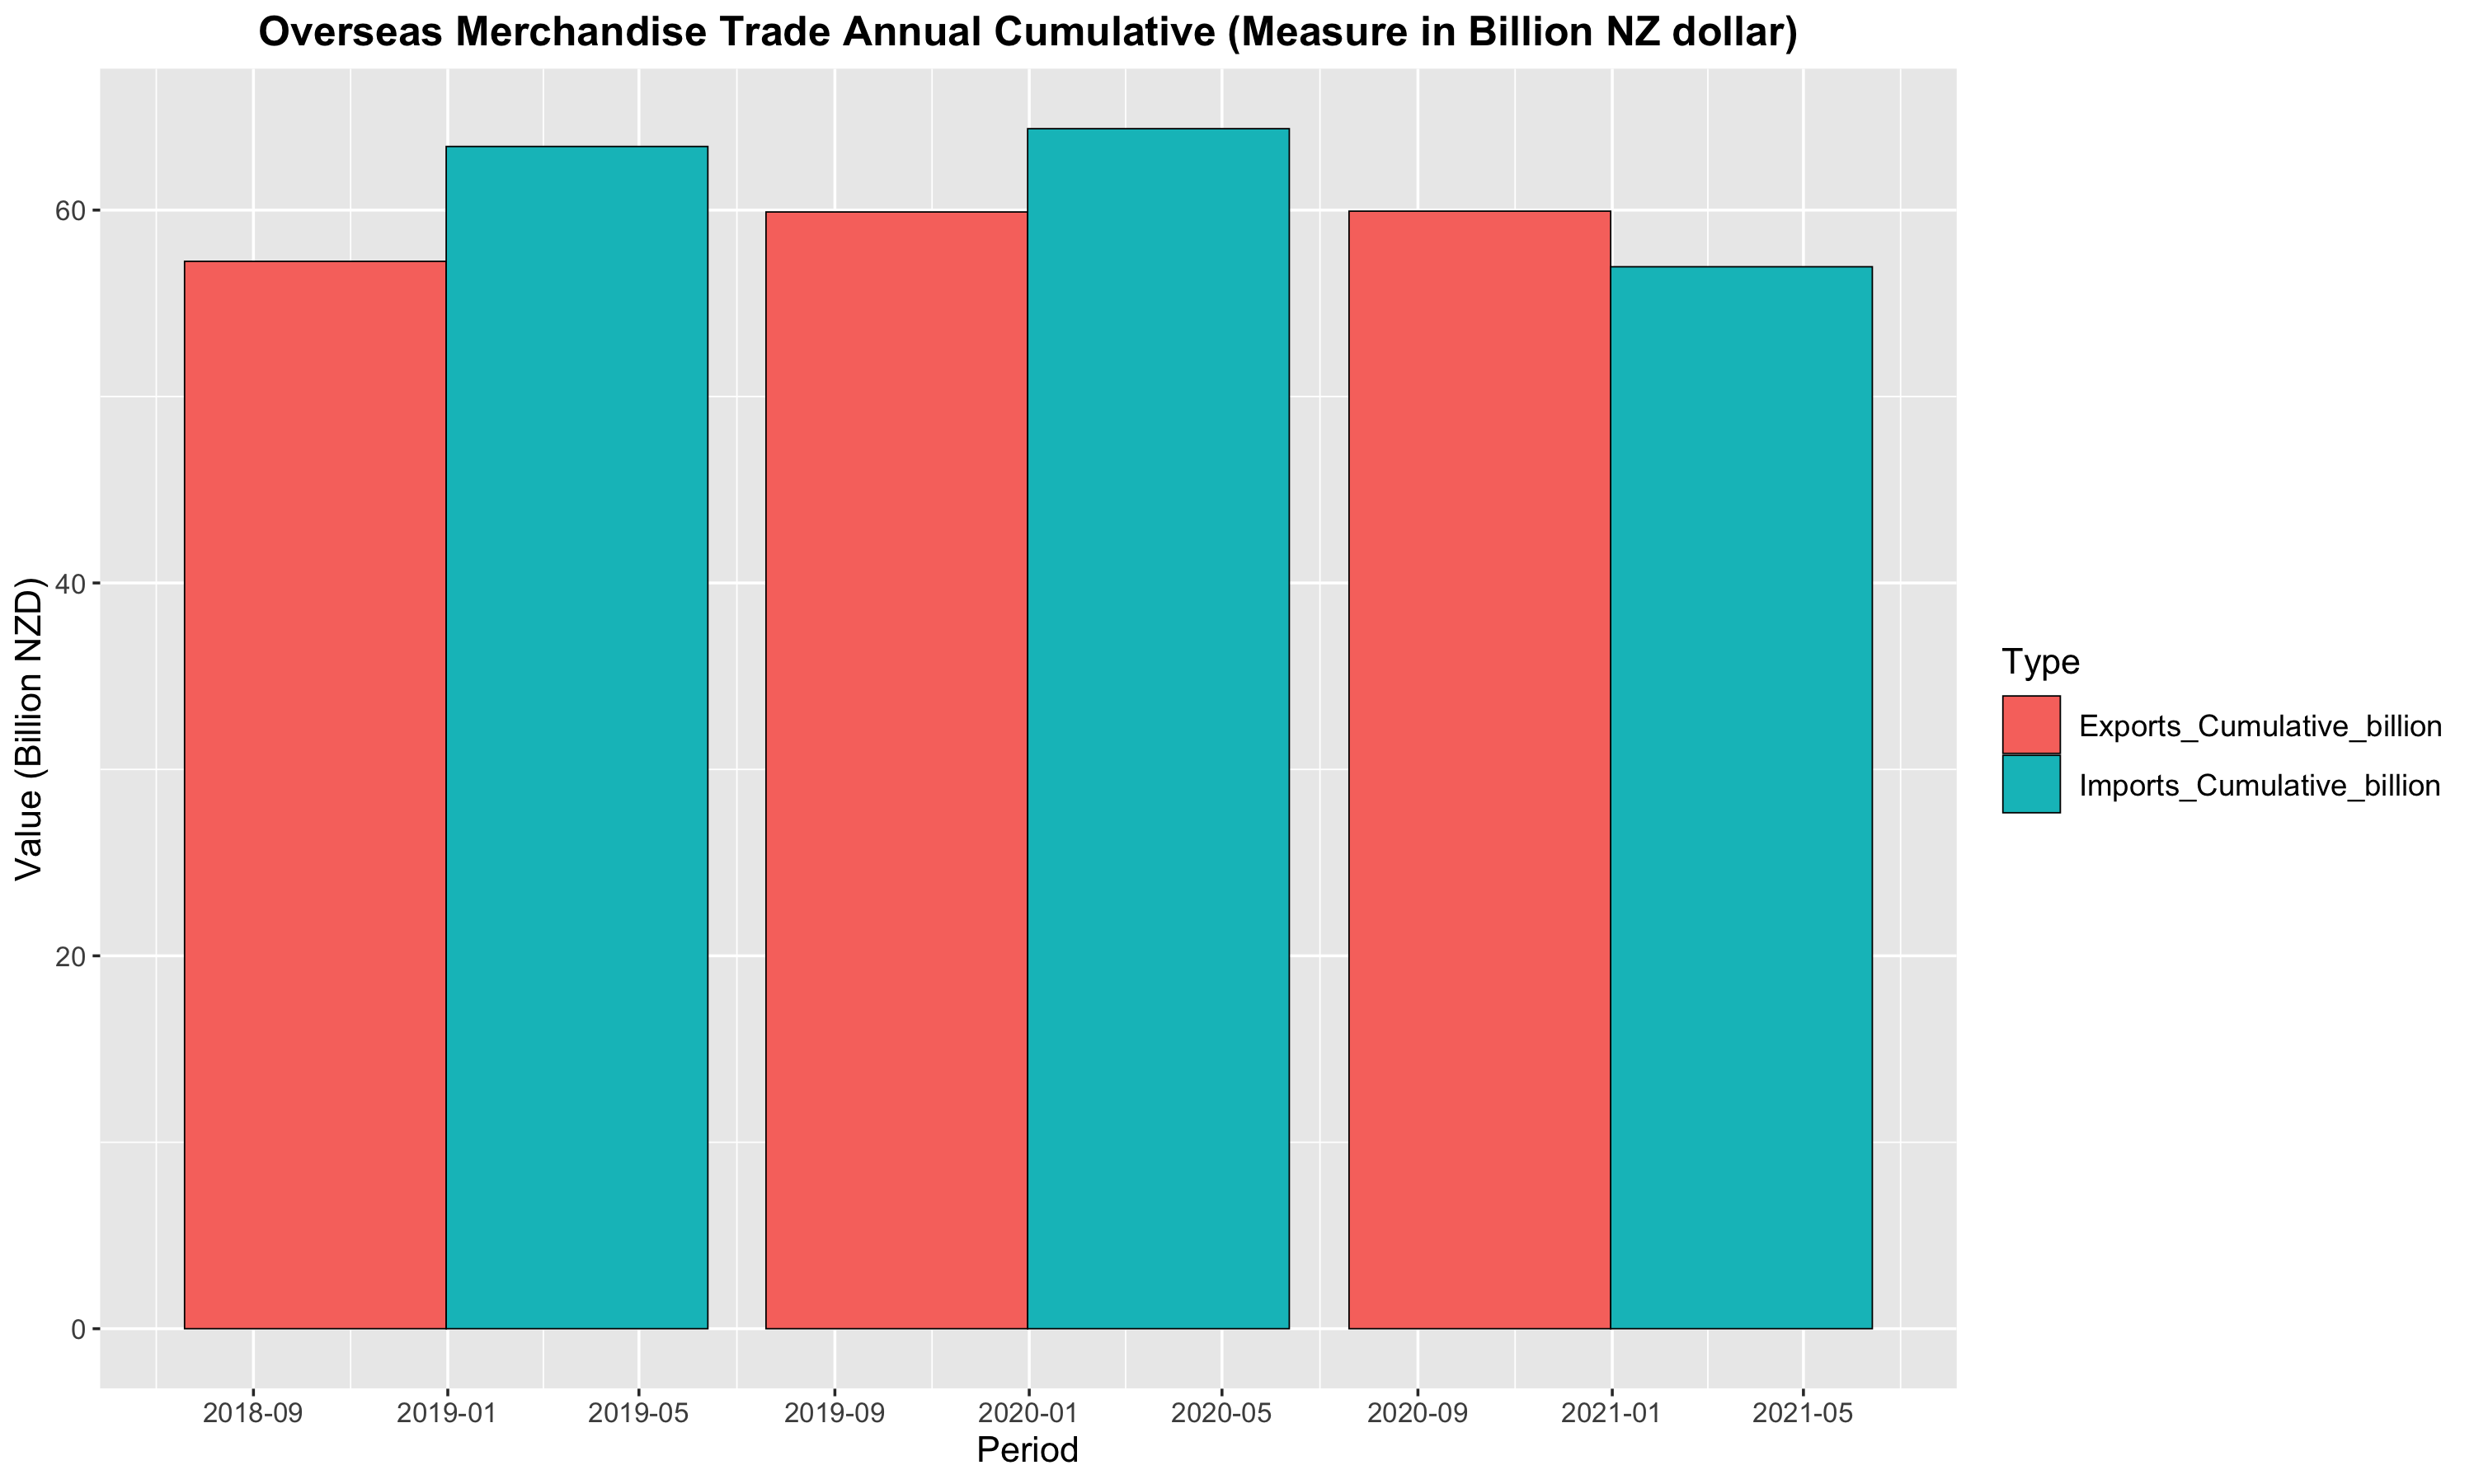

In [50]:
trade_plot <- final_long[grep(pattern="billion$",final_long$Type),] # select the trade related data
trade_plot <- trade_plot[grep(pattern="12-31$",trade_plot$Period),] # only select the last day in one year to get cumulative value
ggplot(data=trade_plot, aes(x=Period, y = Value, fill = Type))+#set X axis as Period and set Y axis as Import value
  #poilt to bar in the graph 
  geom_bar(position = "dodge", stat = "identity", colour = "black")+  
  scale_color_manual(values = c("red","blue"))+#set the color
  scale_x_date(breaks = datebreaks, labels = date_format("%Y-%m")) + # format the x axis period
  labs(title = "Overseas Merchandise Trade Annual Cumulative (Measure in Billion NZ dollar)")+#set the title context
  theme(plot.title = element_text(hjust=0.5,size = 30, face="bold")) + # change title format
  xlab("Period") + # set x and y axis title
  ylab("Value (Billion NZD)") +
  labs(color = "Types of Trade")+ # set legend title
  theme(axis.text.x = element_text(size=20), # change axis x and y format
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size = 26),#set X title size to 26 for better view
        axis.title.y = element_text(size = 26),#set Y title size to 26
        legend.title = element_text(size=26),#set legend title size to 26
        legend.text = element_text(size=22),#set legend text size to 22
        legend.key.size = unit(3, "lines"))

